<a href="https://colab.research.google.com/github/francisco-sanhueza/Workshops/blob/master/Curso_TCGA_RSG_Chile_2025_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalación y carga de librerías

In [37]:
# =============================================================================
# CONFIGURACIÓN INICIAL DEL ENTORNO DE TRABAJO
# =============================================================================

# Establecer el directorio de trabajo donde se instalarán las librerías de R
# Este directorio es típicamente usado para librerías del sistema en Linux
setwd("/usr/local/lib/R/site-library")

# Establecer semilla para reproducibilidad de análisis que involucren aleatoriedad
# Usar 2025 como semilla permite replicar exactamente los mismos resultados
set.seed(2025)

# =============================================================================
# DESCARGA Y EXTRACCIÓN DE LIBRERÍAS R DESDE GOOGLE DRIVE
# =============================================================================

# ID único del archivo comprimido de librerías R almacenado en Google Drive
# Este archivo contiene todas las librerías necesarias para el análisis
google_drive_file_id <- "1XRafx6fVfpfjXO4cYa43MpLO9jYOXTOz"

# Nombre local para el archivo ZIP que se descargará
zip_file <- "R_libraries.zip"

# Verificar que el directorio actual existe, si no, crearlo recursivamente
# El "." se refiere al directorio actual (donde estamos trabajando)
if (!dir.exists(".")) dir.create(".", recursive = TRUE)

# Descargar el archivo ZIP usando la herramienta gdown (interfaz de Google Drive)
# gdown es una utilidad de línea de comandos para descargar archivos de Google Drive
system(paste("gdown --id", google_drive_file_id, "--output", zip_file))

# Extraer el contenido del archivo ZIP al directorio actual
# exdir especifica el directorio de extracción
unzip(zip_file, exdir = ".")

# =============================================================================
# CAMBIO DE DIRECTORIO PARA DESCARGA DE DATOS
# =============================================================================

# Cambiar al directorio /content donde se almacenarán los archivos de datos
# Este es típicamente el directorio de trabajo en entornos como Google Colab
setwd("/content")

# =============================================================================
# CONFIGURACIÓN DE ARCHIVOS DE DATOS PARA DESCARGA MASIVA
# =============================================================================

# Crear un data frame con la información de todos los archivos a descargar
# Esto evita repetir código y permite procesamiento vectorizado
files_data <- data.frame(
  # IDs únicos de Google Drive para cada archivo de datos
  id = c("1NxxlMBDyO2a5cJwLLgRvXGtg7mTgHhyZ",  # Datos TCGA de cáncer de mama
         "1HvDh6qyXAvR86kJo8mMRnTbmEQw1Pjii",  # Objeto DESeqDataSet procesado
         "1gZta0Hu2BXrz8fxtACfMLChIlJQDg2Wa",  # Datos transformados con VST
         "1kclx8rzY_5MF4r87ME0fPTDG_tVetnZE"), # Base de datos de pathways MSigDB

  # Nombres de archivo correspondientes para cada descarga
  filename = c("tcga_brca.rds",                    # Datos crudos TCGA-BRCA
               "dds.rds",                          # DESeqDataSet para análisis diferencial
               "vst.rds",                          # Datos normalizados y transformados
               "h.all.v2024.1.Hs.symbols.gmt"),   # Hallmark gene sets humanos

  # Evitar conversión automática de caracteres a factores
  stringsAsFactors = FALSE
)

# =============================================================================
# DESCARGA MASIVA DE ARCHIVOS DE DATOS
# =============================================================================

# Descargar todos los archivos usando mapply para procesamiento vectorizado
# mapply aplica una función a múltiples listas/vectores simultáneamente
# invisible() oculta la salida de mapply (que normalmente muestra códigos de retorno)
invisible(mapply(function(id, filename) {
  # Para cada par (ID, nombre_archivo), ejecutar comando de descarga
  # Construir y ejecutar comando gdown con parámetros específicos
  system(paste("gdown --id", id, "--output", filename))
}, files_data$id, files_data$filename))

# =============================================================================
# CREACIÓN DE DIRECTORIO PARA GRÁFICOS
# =============================================================================

# Crear directorio 'plots' para almacenar visualizaciones generadas
# Solo se crea si no existe previamente (evita errores)
if (!dir.exists("plots")) dir.create("plots")

# =============================================================================
# INSTALACIÓN INTELIGENTE DE PAQUETES DE R
# =============================================================================

# Lista de paquetes necesarios disponibles en CRAN
packages_to_install <- c("msigdbr",    # Base de datos de gene sets moleculares
                         "remotes",    # Para instalar paquetes desde repositorios remotos
                         "pheatmap")   # Para generar heatmaps de alta calidad

# Identificar qué paquetes NO están instalados actualmente
# installed.packages() devuelve matriz con información de paquetes instalados
# Comparar con nuestra lista para encontrar paquetes faltantes
new_packages <- packages_to_install[!(packages_to_install %in% installed.packages()[,"Package"])]

# Instalar solo los paquetes que realmente faltan (optimización importante)
# Evita reinstalaciones innecesarias que consumen tiempo y recursos
if(length(new_packages)) install.packages(new_packages)

# =============================================================================
# INSTALACIÓN DE PAQUETE DESDE GITHUB
# =============================================================================

# Verificar si EnhancedVolcano (para volcano plots) está instalado
# Este paquete no está en CRAN, debe instalarse desde GitHub
if(!"EnhancedVolcano" %in% installed.packages()[,"Package"]) {
  # Instalar desde el repositorio de GitHub del desarrollador
  # kevinblighe/EnhancedVolcano es la ubicación del código fuente
  remotes::install_github("kevinblighe/EnhancedVolcano")
}

In [3]:
# =============================================================================
# LIBRERÍAS PARA ANÁLISIS DE DATOS
# =============================================================================

# -----------------------------------------------------------------------------
# ACCESO Y DESCARGA DE DATOS GENÓMICOS
# -----------------------------------------------------------------------------

# TCGAbiolinks: Interfaz para acceder a datos de The Cancer Genome Atlas (TCGA)
# TCGA es la base de datos más grande de genómica del cáncer a nivel mundial
# Permite descargar datos de expresión génica, mutaciones, datos clínicos, etc.
# Facilita la búsqueda, filtrado y descarga de muestras específicas de cáncer
library(TCGAbiolinks)

# SummarizedExperiment: Estructura de datos estándar para experimentos genómicos
# Combina matrices de datos (expresión génica) con metadatos de muestras y genes
# Es el formato estándar usado por Bioconductor para almacenar datos ómicos
# Permite acceso eficiente a datos experimentales y sus anotaciones asociadas
library(SummarizedExperiment)

# -----------------------------------------------------------------------------
# ANÁLISIS DE EXPRESIÓN DIFERENCIAL
# -----------------------------------------------------------------------------

# DESeq2: Paquete líder para análisis de expresión diferencial con RNA-seq
# Identifica genes que se expresan de manera diferencial entre condiciones
# Maneja la normalización, estimación de dispersión y pruebas estadísticas
# Especialmente diseñado para datos de conteo (RNA-seq, ChIP-seq, etc.)
library(DESeq2)

# limma: Modelos lineales para análisis de datos de microarrays y RNA-seq
# Permite análisis de expresión diferencial con diseños experimentales complejos
# Incluye métodos para corrección de efectos batch y análisis de múltiples factores
# Muy eficiente computacionalmente para grandes conjuntos de datos
library(limma)

# -----------------------------------------------------------------------------
# VISUALIZACIÓN DE DATOS
# -----------------------------------------------------------------------------

# ggplot2: Sistema de gráficos basado en la "Gramática de Gráficos"
# Permite crear visualizaciones complejas y elegantes de manera intuitiva
# Es la librería estándar para visualización en R por su flexibilidad
# Ideal para gráficos exploratorios y publicaciones científicas
library(ggplot2)

# -----------------------------------------------------------------------------
# ANOTACIÓN GENÓMICA Y ANÁLISIS FUNCIONAL
# -----------------------------------------------------------------------------

# org.Hs.eg.db: Base de datos de anotaciones para el genoma humano
# Contiene mapeos entre diferentes identificadores de genes (Entrez, Symbol, Ensembl)
# Incluye información sobre funciones génicas, localización cromosómica, etc.
# Esencial para convertir entre diferentes sistemas de nomenclatura génica
library(org.Hs.eg.db)

# clusterProfiler: Análisis de enriquecimiento funcional y visualización
# Realiza análisis de Gene Ontology (GO), KEGG pathways, y otras bases de datos
# Identifica procesos biológicos sobre-representados en listas de genes
# Incluye múltiples métodos de visualización (dotplots, heatmaps, redes)
library(clusterProfiler)

# -----------------------------------------------------------------------------
# MANIPULACIÓN EFICIENTE DE DATOS
# -----------------------------------------------------------------------------

# data.table: Extensión de data.frame para manipulación rápida de datos grandes
# Hasta 100x más rápido que data.frame estándar para operaciones comunes
# Sintaxis optimizada para filtrado, agrupación y agregación de datos
# Ideal para datasets genómicos que pueden tener millones de filas
library(data.table)

# -----------------------------------------------------------------------------
# ANÁLISIS DE SUPERVIVENCIA
# -----------------------------------------------------------------------------

# survival: Funciones fundamentales para análisis de supervivencia
# Implementa modelos de Cox, Kaplan-Meier, y otras técnicas de supervivencia
# Esencial para estudios oncológicos donde se analiza tiempo hasta evento
# Permite modelar factores pronósticos y predictivos en cáncer
library(survival)

# survminer: Visualización elegante para análisis de supervivencia
# Complementa el paquete survival con gráficos de alta calidad
# Genera curvas de Kaplan-Meier, forest plots, y gráficos de riesgo
# Optimizado para publicaciones científicas con opciones de personalización
library(survminer)

# -----------------------------------------------------------------------------
# ANÁLISIS AVANZADO DE ANOTACIONES
# -----------------------------------------------------------------------------

# AnnotationDbi: Interfaz para bases de datos de anotaciones biológicas
# Proporciona métodos unificados para acceder a diferentes tipos de anotaciones
# Facilita la conversión entre identificadores y extracción de metadatos génicos
# Base para muchos otros paquetes de anotación en Bioconductor
library(AnnotationDbi)

# -----------------------------------------------------------------------------
# ANÁLISIS DE ENRIQUECIMIENTO DE PATHWAYS
# -----------------------------------------------------------------------------

# fgsea: Fast Gene Set Enrichment Analysis (análisis rápido de conjuntos génicos)
# Implementación ultra-rápida del algoritmo GSEA clásico
# Identifica pathways biológicos enriquecidos en listas de genes ranqueados
# Permite análisis de miles de gene sets en segundos
library(fgsea)

# -----------------------------------------------------------------------------
# MANIPULACIÓN Y TRANSFORMACIÓN DE DATOS
# -----------------------------------------------------------------------------

# tidyverse: Colección de paquetes para ciencia de datos moderna
# Incluye dplyr (manipulación), tidyr (reestructuración), readr (lectura)
# Filosofía de "datos ordenados" (tidy data) para análisis reproducible
# Sintaxis intuitiva y consistente para transformación de datos
library(tidyverse)

# -----------------------------------------------------------------------------
# BASES DE DATOS DE GENE SETS MOLECULARES
# -----------------------------------------------------------------------------

# msigdbr: Acceso a la base de datos MSigDB (Molecular Signatures Database)
# MSigDB contiene >30,000 conjuntos de genes curados manualmente
# Incluye Hallmark gene sets, KEGG, Reactome, Gene Ontology, etc.
# Fundamental para análisis de enriquecimiento y interpretación biológica
library(msigdbr)

# -----------------------------------------------------------------------------
# VISUALIZACIÓN ESPECIALIZADA
# -----------------------------------------------------------------------------

# EnhancedVolcano: Gráficos volcano mejorados para expresión diferencial
# Visualiza significancia estadística vs. magnitud del cambio (fold-change)
# Permite identificar visualmente genes más importantes en experimentos
# Altamente personalizable con etiquetas, colores y filtros
library(EnhancedVolcano)

# ggpubr: Gráficos listos para publicación basados en ggplot2
# Simplifica la creación de gráficos con formato de revista científica
# Incluye funciones para comparaciones estadísticas y anotaciones
# Combina múltiples gráficos y añade estadísticas automáticamente
library(ggpubr)

# pheatmap: Heatmaps (mapas de calor) de alta calidad y personalización
# Visualiza patrones en matrices de datos (expresión génica, correlaciones)
# Incluye clustering jerárquico automático y anotaciones de filas/columnas
# Ideal para mostrar patrones de co-expresión y clasificar muestras
library(pheatmap)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

### Exploración, descarga y preprocesamiento de datos del GDC

In [4]:
# Exploremos el GDC
GDCprojects = getGDCprojects()
head(GDCprojects)


,id,primary_site,dbgap_accession_number,project_id,disease_type,name,releasable,state,released,tumor
,<chr>,<list>,<chr>,<chr>,<list>,<chr>,<lgl>,<chr>,<lgl>,<chr>
1,HCMI-CMDC,"Ovary, B....",NA,HCMI-CMDC,Transiti....,NCI Cancer Model Development for the Human Cancer Model Initiative,TRUE,open,TRUE,CMDC
2,MMRF-COMMPASS,Hematopo....,phs000748,MMRF-COMMPASS,Plasma C....,Multiple Myeloma CoMMpass Study,TRUE,open,TRUE,COMMPASS
3,CDDP_EAGLE-1,Bronchus....,phs001239,CDDP_EAGLE-1,Adenomas....,CDDP Integrative Analysis of Lung Adenocarcinoma (Phase 2),TRUE,open,TRUE,1
4,MP2PRT-WT,Kidney,phs001965,MP2PRT-WT,Neoplasm....,Molecular Profiling to Predict Response to Treatment - Wilms Tumor,FALSE,open,TRUE,WT
5,TCGA-BRCA,Breast,NA,TCGA-BRCA,Fibroepi....,Breast Invasive Carcinoma,TRUE,open,TRUE,BRCA
6,TCGA-UCEC,Corpus u....,NA,TCGA-UCEC,Not Repo....,Uterine Corpus Endometrial Carcinoma,TRUE,open,TRUE,UCEC


In [5]:
head(GDCprojects[c("project_id", "name")], 10)

,project_id,name
,<chr>,<chr>
1,HCMI-CMDC,NCI Cancer Model Development for the Human Cancer Model Initiative
2,MMRF-COMMPASS,Multiple Myeloma CoMMpass Study
3,CDDP_EAGLE-1,CDDP Integrative Analysis of Lung Adenocarcinoma (Phase 2)
4,MP2PRT-WT,Molecular Profiling to Predict Response to Treatment - Wilms Tumor
5,TCGA-BRCA,Breast Invasive Carcinoma
6,TCGA-UCEC,Uterine Corpus Endometrial Carcinoma
7,CTSP-DLBCL1,CTSP Diffuse Large B-Cell Lymphoma (DLBCL) CALGB 50303
8,MATCH-P,Genomic Characterization CS-MATCH-0007 Arm P
9,MATCH-W,Genomic Characterization CS-MATCH-0007 Arm W


In [6]:
# =============================================================================
# OBTENCIÓN DE RESUMEN ESTADÍSTICO DEL PROYECTO TCGA-BRCA
# =============================================================================

# -----------------------------------------------------------------------------
# FUNCIÓN DE EXPLORACIÓN DE PROYECTO
# -----------------------------------------------------------------------------

# getProjectSummary es una función interna de TCGAbiolinks (indicado por :::)
# Los tres puntos (:::)
TCGAbiolinks:::getProjectSummary("TCGA-BRCA")

# -----------------------------------------------------------------------------
# QUÉ INFORMACIÓN PROPORCIONA ESTA FUNCIÓN
# -----------------------------------------------------------------------------

# Esta función consulta el portal GDC (Genomic Data Commons) y retorna estadísticas
# generales del proyecto

# PLANIFICACIÓN DE ANÁLISIS:
# Permite saber exactamente qué tipos de datos están disponibles
# antes de diseñar el pipeline de análisis bioinformático

,file_count,case_count,data_category
,<int>,<int>,<chr>
1,21437,1098,Simple Nucleotide Variation
2,9282,1098,Sequencing Reads
3,5317,1098,Biospecimen
4,2288,1098,Clinical
5,14346,1098,Copy Number Variation
6,4876,1097,Transcriptome Profiling
7,3714,1097,DNA Methylation
8,919,881,Proteome Profiling
9,3128,927,Somatic Structural Variation


In [7]:
# =============================================================================
# DESCARGA Y PREPARACIÓN DE DATOS DE TCGA (THE CANCER GENOME ATLAS)
# =============================================================================

# -----------------------------------------------------------------------------
# DEFINICIÓN DEL PROYECTO DE CÁNCER
# -----------------------------------------------------------------------------

# Especificamos el proyecto TCGA de interés usando el código estándar
# TCGA-BRCA corresponde a Breast invasive carcinoma (Carcinoma invasivo de mama)
# TCGA tiene códigos específicos para cada tipo de cáncer:
# - BRCA: Cáncer de mama
# - LUAD: Adenocarcinoma de pulmón
# - COAD: Adenocarcinoma de colon
# - PRAD: Adenocarcinoma de próstata, etc.
project <- "TCGA-BRCA"

# -----------------------------------------------------------------------------
# CONFIGURACIÓN DE LA CONSULTA A LA BASE DE DATOS GDC
# -----------------------------------------------------------------------------

# GDCquery construye una consulta estructurada al Genomic Data Commons (GDC)
# GDC es el repositorio actual donde se almacenan todos los datos de TCGA
# Esta función NO descarga datos, solo prepara la consulta con filtros específicos

query <- GDCquery(
  # Proyecto específico de cáncer a consultar
  project = project,

  # Categoría principal de datos que queremos obtener
  # "Transcriptome Profiling" incluye todos los datos de transcriptómica
  # Otras opciones: "Simple Nucleotide Variation", "Copy Number Variation", etc.
  data.category = "Transcriptome Profiling",

  # Tipo específico de dato dentro de la categoría
  # "Gene Expression Quantification" se refiere a matrices de expresión génica
  # Contiene los valores numéricos de expresión para cada gen y muestra
  data.type = "Gene Expression Quantification",

  # Estrategia experimental utilizada para generar los datos
  # "RNA-Seq" indica secuenciación de ARN (transcriptoma completo)
  # Alternativas: "miRNA-Seq" para microARNs, etc.
  experimental.strategy = "RNA-Seq",

  # Pipeline bioinformático usado para procesar las secuencias crudas
  # "STAR - Counts" utiliza el alineador STAR seguido de conteo de lecturas
  # STAR es uno de los alineadores más precisos y rápidos disponibles
  # "Counts" significa que obtenemos conteos crudos (no normalizados)
  workflow.type = "STAR - Counts",

  # Tipo de muestra biológica que queremos analizar
  # "Primary Tumor" = tumor primario (sitio original del cáncer)
  # Otras opciones importantes:
  # - "Solid Tissue Normal": tejido normal adyacente al tumor
  # - "Metastatic": muestras de metástasis
  # - "Blood Derived Normal": sangre de individuos control
  sample.type = "Primary Tumor"
)

# -----------------------------------------------------------------------------
# INFORMACIÓN ADICIONAL SOBRE LA CONSULTA
# -----------------------------------------------------------------------------

# La consulta configurada arriba buscará específicamente:
# ✓ Datos de cáncer de mama (TCGA-BRCA)
# ✓ Expresión génica cuantificada (conteos por gen)
# ✓ Generados mediante RNA-seq
# ✓ Procesados con pipeline STAR-Counts
# ✓ Solo muestras de tumor primario (no metástasis ni tejido normal)

# Esta configuración típicamente retorna:
# - ~1,100 muestras de tumor primario de mama
# - ~60,000 genes cuantificados por muestra
# - Conteos crudos (números enteros) listos para análisis con DESeq2
# - Aproximadamente 2-3 GB de datos para descargar

# -----------------------------------------------------------------------------
# DESCARGA EFECTIVA DE LOS DATOS (COMENTADO PARA EVITAR DESCARGA AUTOMÁTICA)
# -----------------------------------------------------------------------------

# GDCdownload ejecuta la descarga real de los archivos desde el servidor GDC
# Descarga todos los archivos que coinciden con la consulta definida arriba
# Los archivos se guardan localmente en una estructura de carpetas organizada
# ADVERTENCIA: Puede tomar 30-60 minutos dependiendo de la conexión a internet
# GDCdownload(query)

# -----------------------------------------------------------------------------
# PREPARACIÓN Y ORGANIZACIÓN DE LOS DATOS DESCARGADOS
# -----------------------------------------------------------------------------

# GDCprepare toma los archivos descargados y los organiza en un objeto R utilizable
# Combina todos los archivos individuales en una matriz unificada
# El resultado es un objeto SummarizedExperiment con:
# - assay(s): matriz de conteos (genes x muestras)
# - rowData: información sobre los genes (símbolos, coordenadas, biotipos)
# - colData: metadatos clínicos de las muestras (edad, estadio, subtipo, supervivencia)

# Este paso puede tomar 10-20 minutos adicionales para procesar todos los archivos
# tcga_brca <- GDCprepare(query)

# -----------------------------------------------------------------------------
# ESTRUCTURA DEL OBJETO RESULTANTE
# -----------------------------------------------------------------------------

# Una vez ejecutado GDCprepare, tcga_brca contendrá:

# MATRIZ DE EXPRESIÓN:
# - Filas: ~60,000 genes (identificados por Ensembl ID)
# - Columnas: ~1,100 muestras de tumor primario
# - Valores: conteos crudos de lecturas de RNA-seq

# METADATOS DE GENES (rowData):
# - gene_id: identificador Ensembl
# - gene_name: símbolo oficial del gen
# - gene_type: tipo de gen (protein_coding, lncRNA, etc.)
# - seqnames: cromosoma donde se ubica el gen

# METADATOS CLÍNICOS (colData):
# - patient: identificador único del paciente
# - sample_type: tipo de muestra (Primary Tumor)
# - tumor_stage: estadio del tumor (I, II, III, IV)
# - age_at_diagnosis: edad al diagnóstico
# - vital_status: estado vital (Alive/Dead)
# - days_to_death: tiempo hasta muerte (para análisis de supervivencia)
# - paper_BRCA_Subtype_PAM50: subtipo molecular de cáncer de mama
# - Y muchos otros campos clínicos relevantes...

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BRCA

--------------------

oo Filtering results

--------------------

ooo By experimental.strategy

ooo By data.type

ooo By workflow.type

ooo By sample.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------



In [8]:
# =============================================================================
# EXTRACCIÓN Y EXPLORACIÓN DE METADATOS DE LA CONSULTA TCGA
# =============================================================================

# -----------------------------------------------------------------------------
# CONVERSIÓN DE CONSULTA A TABLA DE RESULTADOS
# -----------------------------------------------------------------------------

# getResults extrae los metadatos de la consulta GDCquery en formato tabla
# Convierte el objeto de consulta (query) en un data.frame manejable
# NO descarga los datos reales, solo extrae la información de archivos disponibles
# Esta tabla contiene todos los metadatos de los archivos que coinciden con nuestra consulta

tcga_results = getResults(query)

# -----------------------------------------------------------------------------
# EXPLORACIÓN DE LA ESTRUCTURA DE METADATOS
# -----------------------------------------------------------------------------

# colnames() muestra todas las columnas (variables) disponibles en la tabla
# Cada columna representa un tipo diferente de metadata sobre los archivos
# Esta información es crucial para entender qué datos tenemos disponibles

colnames(tcga_results)

[1] "id"                        "data_format"              
 [3] "cases"                     "access"                   
 [5] "file_name"                 "submitter_id"             
 [7] "data_category"             "type"                     
 [9] "platform"                  "file_size"                
[11] "created_datetime"          "md5sum"                   
[13] "updated_datetime"          "file_id"                  
[15] "data_type"                 "state"                    
[17] "experimental_strategy"     "version"                  
[19] "data_release"              "project"                  
[21] "analysis_id"               "analysis_state"           
[23] "analysis_submitter_id"     "analysis_workflow_link"   
[25] "analysis_workflow_type"    "analysis_workflow_version"
[27] "sample_type"               "is_ffpe"                  
[29] "cases.submitter_id"        "sample.submitter_id"

In [9]:
# Revisemos la metadata
head(tcga_results)

,id,data_format,cases,access,file_name,submitter_id,data_category,type,platform,file_size,⋯,analysis_id,analysis_state,analysis_submitter_id,analysis_workflow_link,analysis_workflow_type,analysis_workflow_version,sample_type,is_ffpe,cases.submitter_id,sample.submitter_id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>
1,3396edba-0d2a-4485-ad0a-5114b38c1abe,TSV,TCGA-GM-A2DL-01A-11R-A18M-07,open,2e64abe2-6024-4d28-9e09-560ce2a9fd15.rna_seq.augmented_star_gene_counts.tsv,f7c166d0-fb1c-467f-a6b4-c0dcd6a539e9,Transcriptome Profiling,gene_expression,Illumina,4231290,⋯,10f23d82-414b-4984-bbd8-2f65526b11d3,released,2e64abe2-6024-4d28-9e09-560ce2a9fd15_star__counts,https://github.com/NCI-GDC/gdc-rnaseq-cwl/blob/5d8c131bbff59fb0c969217fc1d44e6d1503cd1f/rnaseq-star-align/star2pass.rnaseq_harmonization.cwl,STAR - Counts,5d8c131bbff59fb0c969217fc1d44e6d1503cd1f,Primary Tumor,NA,TCGA-GM-A2DL,TCGA-GM-A2DL-01A
2,d2e2915c-125e-45c6-b7f3-6a815b3d2859,TSV,TCGA-AC-A2QI-01A-12R-A19W-07,open,96a45a70-d4b5-4090-b603-73b7379679d6.rna_seq.augmented_star_gene_counts.tsv,b67c7992-8357-41d8-86c3-b71c8ada37ef,Transcriptome Profiling,gene_expression,Illumina,4247897,⋯,62764a2a-af86-4543-9e27-e0a71c63b322,released,96a45a70-d4b5-4090-b603-73b7379679d6_star__counts,https://github.com/NCI-GDC/gdc-rnaseq-cwl/blob/5d8c131bbff59fb0c969217fc1d44e6d1503cd1f/rnaseq-star-align/star2pass.rnaseq_harmonization.cwl,STAR - Counts,5d8c131bbff59fb0c969217fc1d44e6d1503cd1f,Primary Tumor,NA,TCGA-AC-A2QI,TCGA-AC-A2QI-01A
3,fb32f0b1-4fb7-43d5-8091-dc13a1f6d9e8,TSV,TCGA-A8-A06R-01A-11R-A00Z-07,open,1d468785-141d-40ca-acb1-d6d85a8c9d7b.rna_seq.augmented_star_gene_counts.tsv,70ea5a0a-27ed-4b05-8d98-57b93e54103f,Transcriptome Profiling,gene_expression,Illumina,4246171,⋯,4dfa070b-5b48-4f1b-9669-a421882b8a8e,released,1d468785-141d-40ca-acb1-d6d85a8c9d7b_star__counts,https://github.com/NCI-GDC/gdc-rnaseq-cwl/blob/5d8c131bbff59fb0c969217fc1d44e6d1503cd1f/rnaseq-star-align/star2pass.rnaseq_harmonization.cwl,STAR - Counts,5d8c131bbff59fb0c969217fc1d44e6d1503cd1f,Primary Tumor,NA,TCGA-A8-A06R,TCGA-A8-A06R-01A
4,de5e449b-bc57-4836-89e4-73a3ba24abdf,TSV,TCGA-EW-A1PD-01A-11R-A144-07,open,748e4eaa-2b96-4dce-a903-c7df733d7f50.rna_seq.augmented_star_gene_counts.tsv,62faa455-eb73-4f50-a8a3-b77f66f528d9,Transcriptome Profiling,gene_expression,Illumina,4245842,⋯,3d309cc3-2946-4767-bac5-b67de90581c1,released,748e4eaa-2b96-4dce-a903-c7df733d7f50_star__counts,https://github.com/NCI-GDC/gdc-rnaseq-cwl/blob/5d8c131bbff59fb0c969217fc1d44e6d1503cd1f/rnaseq-star-align/star2pass.rnaseq_harmonization.cwl,STAR - Counts,5d8c131bbff59fb0c969217fc1d44e6d1503cd1f,Primary Tumor,NA,TCGA-EW-A1PD,TCGA-EW-A1PD-01A
5,a58e2ae3-a236-4209-8292-70465216cb85,TSV,TCGA-AO-A12D-01A-11R-A115-07,open,e614fbb4-7574-4704-9525-c0aea4c10fc6.rna_seq.augmented_star_gene_counts.tsv,a2711d68-6912-4a43-878a-6350f4bff13e,Transcriptome Profiling,gene_expression,Illumina,4236123,⋯,d345a860-c1a7-4960-a506-5a30f56b8db3,released,e614fbb4-7574-4704-9525-c0aea4c10fc6_star__counts,https://github.com/NCI-GDC/gdc-rnaseq-cwl/blob/5d8c131bbff59fb0c969217fc1d44e6d1503cd1f/rnaseq-star-align/star2pass.rnaseq_harmonization.cwl,STAR - Counts,5d8c131bbff59fb0c969217fc1d44e6d1503cd1f,Primary Tumor,NA,TCGA-AO-A12D,TCGA-AO-A12D-01A
6,f7b5d569-1a46-4f23-bfca-a46daacda793,TSV,TCGA-AR-A24N-01A-11R-A169-07,open,ad8c55ae-46df-43cd-8cb5-c049e3019959.rna_seq.augmented_star_gene_counts.tsv,bcdf2a68-2dd6-40ac-80ee-28e91169909f,Transcriptome Profiling,gene_expression,Illumina,4249311,⋯,4d50d048-64a2-4698-93b9-55eeb455271a,released,ad8c55ae-46df-43cd-8cb5-c049e3019959_star__counts,https://github.com/NCI-GDC/gdc-rnaseq-cwl/blob/5d8c131bbff59fb0c969217fc1d44e6d1503cd1f/rnaseq-star-align/star2pass.rnaseq_harmonization.cwl,STAR - Counts,5d8c131bbff59fb0c969217fc1d44e6d1503cd1f,Primary Tumor,NA,TCGA-AR-A24N,TCGA-AR-A24N-01A


In [10]:
# -----------------------------------------------------------------------------
# CARGUEMOS EL DATASET DE CANCER DE MAMA
# -----------------------------------------------------------------------------
# Para agilizar el tutorial, vamos a cargar directamente el dataset.
# De lo contrario, al descargarlo con el comando anterior tomaría más de 10 minutos.
tcga_brca <- readRDS("tcga_brca.rds")

In [11]:
# Revisemos las columnas de metadata clínica
print(colnames(colData(tcga_brca)))

 [1] "barcode"                                  
 [2] "patient"                                  
 [3] "sample"                                   
 [4] "shortLetterCode"                          
 [5] "definition"                               
 [6] "sample_submitter_id"                      
 [7] "sample_type_id"                           
 [8] "tumor_descriptor"                         
 [9] "sample_id"                                
[10] "sample_type"                              
[11] "composition"                              
[12] "days_to_collection"                       
[13] "state"                                    
[14] "initial_weight"                           
[15] "preservation_method"                      
[16] "pathology_report_uuid"                    
[17] "submitter_id"                             
[18] "oct_embedded"                             
[19] "specimen_type"                            
[20] "is_ffpe"                                  
[21] "tissue_type"  

In [12]:
# Veamos la metadata clínica de los primeros 6 pacientes
head(colData(tcga_brca))

DataFrame with 6 rows and 97 columns
                                            barcode      patient
                                        <character>  <character>
TCGA-GM-A2DL-01A-11R-A18M-07 TCGA-GM-A2DL-01A-11R.. TCGA-GM-A2DL
TCGA-AC-A2QI-01A-12R-A19W-07 TCGA-AC-A2QI-01A-12R.. TCGA-AC-A2QI
TCGA-A8-A06R-01A-11R-A00Z-07 TCGA-A8-A06R-01A-11R.. TCGA-A8-A06R
TCGA-EW-A1PD-01A-11R-A144-07 TCGA-EW-A1PD-01A-11R.. TCGA-EW-A1PD
TCGA-AO-A12D-01A-11R-A115-07 TCGA-AO-A12D-01A-11R.. TCGA-AO-A12D
TCGA-AR-A24N-01A-11R-A169-07 TCGA-AR-A24N-01A-11R.. TCGA-AR-A24N
                                       sample shortLetterCode
                                  <character>     <character>
TCGA-GM-A2DL-01A-11R-A18M-07 TCGA-GM-A2DL-01A              TP
TCGA-AC-A2QI-01A-12R-A19W-07 TCGA-AC-A2QI-01A              TP
TCGA-A8-A06R-01A-11R-A00Z-07 TCGA-A8-A06R-01A              TP
TCGA-EW-A1PD-01A-11R-A144-07 TCGA-EW-A1PD-01A              TP
TCGA-AO-A12D-01A-11R-A115-07 TCGA-AO-A12D-01A              TP
TCGA-AR-A

In [13]:
# Inspeccionemos brevemente los datos descargados acorde al subtipo molecular
table(tcga_brca$paper_BRCA_Subtype_PAM50)


 Basal   Her2   LumA   LumB Normal 
   197     82    571    209     40 

In [14]:
# =============================================================================
# FILTRADO Y EXTRACCIÓN DE SUBTIPOS ESPECÍFICOS DE CÁNCER DE MAMA
# =============================================================================

# -----------------------------------------------------------------------------
# DEFINICIÓN DE SUBTIPOS MOLECULARES DE INTERÉS
# -----------------------------------------------------------------------------

# Los subtipos moleculares de cáncer de mama según PAM50 (Prediction Analysis of Microarray 50)
# PAM50 es un panel de 50 genes que clasifica tumores de mama en subtipos pronósticos
# Cada subtipo tiene características biológicas, pronóstico y tratamiento diferentes
# Seleccionaremos 3 subtipos para analizar y comparar en los análisis posteriores

subtipos <- c("Basal", "Her2", "LumA")

# CARACTERÍSTICAS DE CADA SUBTIPO:

# BASAL (Basal-like):
# - También conocido como "Triple Negativo" (ER-, PR-, HER2-)
# - Más agresivo, peor pronóstico
# - Más común en mujeres jóvenes y de ascendencia africana
# - Responde bien a quimioterapia pero opciones de tratamiento limitadas
# - Representa ~15-20% de todos los cánceres de mama

# HER2 (HER2-enriched):
# - Sobreexpresión del receptor HER2/neu
# - Históricamente agresivo, pero con buen pronóstico con terapias dirigidas
# - Responde a trastuzumab (Herceptin) y otros anti-HER2
# - Representa ~15-20% de todos los cánceres de mama

# LUMA (Luminal A):
# - Expresión alta de receptores de estrógeno (ER+)
# - Mejor pronóstico de todos los subtipos
# - Crece lentamente, responde bien a terapia hormonal
# - Más común en mujeres postmenopáusicas
# - Representa ~40% de todos los cánceres de mama

# NOTA: No incluimos LumB (Luminal B) ni Normal-like para simplificar el análisis
# y optimizar los recursos computacionales

# -----------------------------------------------------------------------------
# FILTRADO DEL OBJETO SUMMARIZEDEXPERIMENT
# -----------------------------------------------------------------------------

# Aplicamos filtro lógico para seleccionar solo muestras de los subtipos de interés
# tcga_brca$paper_BRCA_Subtype_PAM50 contiene la clasificación molecular de cada muestra
# El operador %in% verifica si cada muestra pertenece a alguno de nuestros subtipos

subset_brca <- tcga_brca[, tcga_brca$paper_BRCA_Subtype_PAM50 %in% subtipos]

# EXPLICACIÓN DE LA SINTAXIS:
# tcga_brca[filas, columnas] - sintaxis estándar de indexación en R
# filas = vacío (mantenemos todos los genes)
# columnas = condición lógica que filtra muestras por subtipo
# El resultado mantiene la estructura SummarizedExperiment pero solo con muestras seleccionadas

# VENTAJAS DE MANTENER EL FORMATO SUMMARIZEDEXPERIMENT:
# - Preserva la asociación entre datos de expresión y metadatos
# - Mantiene todas las anotaciones de genes (rowData)
# - Conserva la estructura original para funciones de Bioconductor

# -----------------------------------------------------------------------------
# EXTRACCIÓN DE LA MATRIZ DE CONTEOS
# -----------------------------------------------------------------------------

# assay() extrae la matriz numérica principal del objeto SummarizedExperiment
# En nuestro caso, contiene conteos crudos de RNA-seq para cada gen y muestra

conteos <- assay(subset_brca) # matriz de conteos (filas = genes, columnas = muestras)

# ESTRUCTURA DE LA MATRIZ RESULTANTE:
# - Filas (rows): ~60,000 genes identificados por Ensembl ID
# - Columnas (cols): 850 muestras de los 3 subtipos seleccionados
# - Valores: números enteros (conteos crudos de lecturas de RNA-seq)
# - Tipo de datos: matriz numérica (numeric matrix)

# CARACTERÍSTICAS DE LOS CONTEOS CRUDOS:
# - Sin normalización (conservan sesgos técnicos y biológicos)
# - Números enteros no negativos
# - Adecuados para análisis con DESeq2, edgeR, limma-voom

# -----------------------------------------------------------------------------
# EXTRACCIÓN DE METADATOS CLÍNICOS
# -----------------------------------------------------------------------------

# colData() extrae los metadatos asociados a cada muestra (columna)
# as.data.frame() convierte el DataFrame de Bioconductor a data.frame estándar de R

metadatos <- as.data.frame(colData(subset_brca)) # convertimos colData a data.frame para facilidad de manejo

# VENTAJAS DE LA CONVERSIÓN A DATA.FRAME:
# - Mayor compatibilidad con funciones estándar de R
# - Sintaxis más familiar para manipulación de datos
# - Mejor integración con tidyverse y otras librerías
# - Facilita operaciones de filtrado y agrupación

# INFORMACIÓN CONTENIDA EN METADATOS:
# - Identificadores: patient, sample, barcode
# - Subtipos moleculares: paper_BRCA_Subtype_PAM50
# - Variables clínicas: age_at_diagnosis, tumor_stage, grade
# - Información de supervivencia: vital_status, days_to_death
# - Características del tumor: histological_type, sample_type
# - Datos demográficos: gender, race, ethnicity

# -----------------------------------------------------------------------------
# VERIFICACIÓN DE DIMENSIONES
# -----------------------------------------------------------------------------

# Imprimimos las dimensiones para verificar el filtrado exitoso
print(dim(conteos)) # imprime el número de genes y muestras

# -----------------------------------------------------------------------------
# IMPORTANCIA DEL FILTRADO PARA EFECTOS DE ESTE TUTORIAL
# -----------------------------------------------------------------------------

# OPTIMIZACIÓN COMPUTACIONAL:
# - Menor número de muestras = análisis más rápidos
# - Reduce memoria RAM necesaria
# - Facilita visualizaciones (menos puntos en gráficos)

[1] 60660   850


In [15]:
# ==============================================================================
# DEFINICIÓN DE FACTORES DE BATCH PARA DATOS TCGA
# ==============================================================================

# También definimos el factor de batch.
# Usaremos el centro de secuenciación (código del centro en el barcode TCGA) como variable de batch.
# El barcode TCGA completo de cada muestra incluye al final un código de centro de dos dígitos.
# https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/


# BATCH1: Extracción de los últimos 2 dígitos del barcode
# ------------------------------------------------------------------------------
# Extraemos esos dos dígitos finales del barcode para cada muestra:
# - nchar() calcula el número total de caracteres en el barcode
# - start: posición donde empezar la extracción (penúltimo carácter)
# - stop: posición donde terminar la extracción (último carácter)
# Este método extrae los 2 últimos caracteres que representan el código del centro de secuenciación
metadatos$batch1 <- substr(metadatos$barcode,
                          start = nchar(as.character(metadatos$barcode)) - 1,
                          stop = nchar(as.character(metadatos$barcode)))

# BATCH2: Extracción de caracteres en posiciones específicas (6-7)
# ------------------------------------------------------------------------------
# Utilizamos str_sub() de la librería stringr para extraer caracteres
# en posiciones fijas del barcode TCGA
# - Posición 6 a 7: Estas posiciones corresponden al centro donde se tomó la muestra
#   identificador dentro de la estructura del barcode TCGA
# - str_sub() es más eficiente que substr() para extracciones de posición fija
metadatos$batch2 <- str_sub(metadatos$barcode, 6, 7)

# BATCH3: Extracción de caracteres en posiciones específicas (22-25)
# ------------------------------------------------------------------------------
# Extraemos los caracteres de la posición 22 a la 25 del barcode
# - Estas posiciones (22-25) corresponden a 4 caracteres consecutivos
# - En la estructura del barcode TCGA, estas posiciones representan
#  el Código de la placa de secuenciación
# - Este factor de batch puede ser útil para controlar efectos técnicos
#   relacionados con el procesamiento por lotes
metadatos$batch3 <- str_sub(metadatos$barcode, 22, 25)

# NOTAS IMPORTANTES:
# ------------------------------------------------------------------------------
# 1. Los factores de batch son cruciales para el análisis de datos de expresión génica
#    ya que permiten identificar y corregir efectos técnicos no deseados
#
# 2. TCGA (The Cancer Genome Atlas) utiliza un sistema de códigos de barras estandarizado
#    donde cada posición tiene un significado específico para la trazabilidad de muestras
#
# 3. Es recomendable explorar estos factores de batch mediante:
#    - Análisis de componentes principales (PCA)
#    - Análisis de correlación con variables de interés
#    - Visualización mediante gráficos de dispersión o heatmaps
#
# 4. Los diferentes batch factors pueden ser utilizados posteriormente en:
#    - Modelos de regresión para controlar efectos de confusión
#    - Algoritmos de corrección de batch (como ComBat)
#    - Análisis de varianza para cuantificar efectos técnicos

In [16]:
# ==============================================================================
# FILTRADO DE GENES Y CONVERSIÓN DE IDENTIFICADORES
# ==============================================================================

# PASO 1: FILTRAR GENES CON MUY BAJA EXPRESIÓN
# ------------------------------------------------------------------------------
# Eliminamos genes con conteo total muy bajo en todas las muestras,
# ya que difícilmente aportarán información biológicamente relevante.
# Los genes con muy pocos conteos introducen ruido y pueden generar
# resultados estadísticamente poco confiables.

# Definir criterios de filtrado
min_conteos   <- 10                               # Mínimo de 10 lecturas por muestra
min_muestras  <- ceiling(0.5 * ncol(conteos))    # Al menos el 50% de las muestras

# EXPLICACIÓN DE LOS CRITERIOS:
# - min_conteos: Un gen debe tener al menos 10 lecturas en una muestra
#   para ser considerado como "expresado" en esa muestra
# - min_muestras: Calculamos el 50% del número total de muestras usando ceiling()
#   ceiling() redondea hacia arriba para asegurar un número entero de muestras
# - Un gen se mantiene solo si cumple el criterio de min_conteos en
#   al menos min_muestras muestras

# Aplicar el filtro
# rowSums(conteos >= min_conteos): cuenta en cuántas muestras cada gen
# tiene al menos min_conteos lecturas
# >= min_muestras: verifica si esta cantidad es mayor o igual al mínimo requerido
keep <- rowSums(conteos >= min_conteos) >= min_muestras

# Verificar cuántos genes pasan el filtro mediante una tabla
# Muestra cuántos genes se mantienen (TRUE) y cuántos se eliminan (FALSE)
table(keep)

# Crear la matriz filtrada manteniendo solo los genes que pasan el criterio
conteos_filt <- conteos[keep, ]

# PASO 2: CONVERSIÓN DE IDENTIFICADORES ENSEMBL A SÍMBOLOS DE GENES
# ------------------------------------------------------------------------------
# Los datos de TCGA utilizan identificadores Ensembl (formato: ENSG00000000001.X)
# Para mayor interpretabilidad, los convertimos a símbolos de genes (ej: TP53, BRCA1)

# Extraer solo la parte del ID Ensembl sin la versión
# Los IDs Ensembl tienen formato "ENSGXXXXXXXXXXX.version"
# strsplit() divide cada ID por el punto "."
# sapply(..., `[`, 1) extrae el primer elemento (antes del punto)
ensembl_ids <- sapply(strsplit(rownames(conteos_filt), "\\."), `[`, 1)

# Mapear IDs Ensembl a símbolos de genes usando la base de datos org.Hs.eg.db
# mapIds() realiza la conversión entre diferentes tipos de identificadores
gene_symbols <- mapIds(org.Hs.eg.db,           # Base de datos de anotación humana
                       keys = ensembl_ids,      # IDs Ensembl como entrada
                       column = "SYMBOL",       # Queremos obtener símbolos de genes
                       keytype = "ENSEMBL",     # Tipo de identificador de entrada
                       multiVals = "first")     # Si hay múltiples símbolos, tomar el primero

# PASO 3: CREAR MATRIZ ANOTADA Y LIMPIAR DATOS
# ------------------------------------------------------------------------------
# Combinar símbolos de genes con los datos de expresión
expr_anno <- data.frame(Symbol = gene_symbols,    # Primera columna: símbolos de genes
                        conteos_filt,              # Resto de columnas: datos de expresión
                        check.names = FALSE)       # Mantener nombres originales de columnas

# Eliminar filas donde no se pudo mapear el símbolo del gen (valores NA)
# Esto ocurre cuando un ID Ensembl no tiene correspondencia en la base de datos
expr_anno <- expr_anno[!is.na(expr_anno$Symbol), ]

# PASO 4: AGREGAR CONTEOS POR SÍMBOLO DE GEN
# ------------------------------------------------------------------------------
# Algunos genes pueden tener múltiples IDs Ensembl (diferentes isoformas)
# Sumamos los conteos de todas las isoformas para obtener la expresión total del gen

expr_anno_sum <- expr_anno %>%
  group_by(Symbol) %>%                           # Agrupar por símbolo de gen
  summarise(across(where(is.numeric), sum))     # Sumar todos los valores numéricos por grupo

# EXPLICACIÓN DE LA AGREGACIÓN:
# - group_by(Symbol): agrupa filas que tienen el mismo símbolo de gen
# - across(where(is.numeric), sum): suma todos los valores numéricos
#   (conteos de expresión) dentro de cada grupo
# - Esto colapsa múltiples isoformas del mismo gen en una sola entrada

# PASO 5: FORMATEAR LA MATRIZ FINAL
# ------------------------------------------------------------------------------
# Convertir de tibble a data.frame para mantener compatibilidad
expr_anno_sum <- as.data.frame(expr_anno_sum)

# Establecer símbolos de genes como nombres de filas
rownames(expr_anno_sum) <- expr_anno_sum$Symbol

# Eliminar la columna Symbol ya que ahora está en los nombres de filas
expr_anno_sum$Symbol <- NULL

# PASO 6: LIMPIEZA DE MEMORIA
# ------------------------------------------------------------------------------
# Eliminar objetos intermedios para liberar memoria
# Estos objetos ya no son necesarios para análisis posteriores
rm(expr_anno, conteos)

# RESULTADO FINAL:
# ------------------------------------------------------------------------------
# expr_anno_sum: matriz de expresión génica filtrada y anotada
# - Filas: genes (símbolos de genes como nombres de filas)
# - Columnas: muestras (barcodes TCGA)
# - Valores: conteos de expresión agregados por gen
# - Solo incluye genes con expresión suficiente según nuestros criterios
# - Genes duplicados (múltiples isoformas) han sido colapsados sumando sus conteos

keep
FALSE  TRUE 
40547 20113 

'select()' returned 1:many mapping between keys and columns



In [17]:
# Revisemos la matriz de expresión filtrada
head(expr_anno_sum)

,TCGA-GM-A2DL-01A-11R-A18M-07,TCGA-AC-A2QI-01A-12R-A19W-07,TCGA-AO-A12D-01A-11R-A115-07,TCGA-AR-A24U-01A-11R-A169-07,TCGA-D8-A1JU-01A-11R-A13Q-07,TCGA-A8-A0AD-01A-11R-A056-07,TCGA-E2-A3DX-01A-21R-A213-07,TCGA-A2-A0YL-01A-21R-A109-07,TCGA-C8-A12P-01A-11R-A115-07,TCGA-AO-A0JA-01A-11R-A056-07,⋯,TCGA-D8-A27F-01A-11R-A16F-07,TCGA-EW-A1P4-01A-21R-A144-07,TCGA-AO-A0JC-01A-11R-A056-07,TCGA-B6-A0X1-01A-11R-A109-07,TCGA-E9-A1N3-01A-12R-A157-07,TCGA-AN-A0FS-01A-11R-A034-07,TCGA-LD-A7W5-01A-22R-A352-07,TCGA-C8-A8HP-01A-11R-A36F-07,TCGA-EW-A3U0-01A-11R-A22K-07,TCGA-V7-A7HQ-01A-11R-A33J-07
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A1BG,3,17,3,10,24,14,13,8,7,12,⋯,6,3,16,4,60,10,12,10,4,8
A1BG-AS1,68,151,29,49,163,126,79,88,31,65,⋯,48,77,64,42,174,128,82,106,65,31
A2M,25594,50744,27623,38667,60538,21638,72358,92662,33036,46807,⋯,154177,12380,27421,3485,22259,52378,39085,14713,98578,8780
A2M-AS1,40,59,34,49,106,45,92,104,63,101,⋯,79,104,69,66,53,100,128,19,149,13
A2ML1,2,11,394,9486,8,3,103,16,365,180,⋯,59,3637,209,1879,8,17,33,43,233,73
A4GALT,1423,1388,362,416,1474,434,1769,650,517,707,⋯,2587,3151,1171,935,233,996,1528,512,960,2603


In [18]:
# LIMPIEZA DE MEMORIA
# ------------------------------------------------------------------------------
# Eliminar objetos intermedios para liberar memoria
# Estos objetos ya no son necesarios para análisis posteriores
rm(tcga_brca)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,9298376,496.6,59033639,3152.8,73792048,3941.0
Vcells,267389380,2040.1,840663636,6413.8,720921255,5500.2


### Análisis de expresión diferencial

In [19]:
# ==============================================================================
# CREACIÓN Y CONFIGURACIÓN DE OBJETO DESEQ2
# ==============================================================================

# PASO 1: PREPARACIÓN DE METADATOS (colData)
# ------------------------------------------------------------------------------
# Vamos a crear un objeto DESeq2
# Usamos DESeq2 para calcular factores de normalización y preparar datos
# para análisis diferencial de expresión génica.

# DESeq2 requiere un data.frame con metadata de las muestras (colData)
# que contenga las variables experimentales y factores de confusión

col_data <- data.frame(
  # VARIABLE PRINCIPAL DE INTERÉS:
  condition = metadatos$paper_BRCA_Subtype_PAM5,  # Subtipo de cáncer de mama según PAM50

  # FACTORES DE BATCH:
  batch1 = metadatos$batch1, # Código del centro de secuenciación (últimos 2 dígitos)
  batch2 = metadatos$batch2, # Código del centro de toma de muestra (posiciones 6-7)
  batch3 = metadatos$batch3, # Código de la placa de secuenciación (posiciones 22-25)

  # NOMBRES DE FILAS:
  row.names = rownames(metadatos) # Barcodes TCGA como identificadores de muestra
)

# PASO 2: CREACIÓN DEL OBJETO DESEQ2
# ------------------------------------------------------------------------------
# DESeqDataSetFromMatrix() crea el objeto DESeq2 principal
dds <- DESeqDataSetFromMatrix(
  countData = expr_anno_sum,    # Matriz de conteos (genes x muestras)
  colData = col_data,           # Metadatos de las muestras
  design = ~ condition          # Fórmula del diseño experimental
)

# EXPLICACIÓN DE LOS PARÁMETROS:
# - countData: Matriz con conteos de expresión génica
#   * Filas = genes (símbolos de genes)
#   * Columnas = muestras (barcodes TCGA)
#   * Valores = conteos de lecturas (integers)
# - colData: Data.frame con información de las muestras
#   * Debe tener el mismo número de filas que columnas en countData
#   * Los nombres de filas deben coincidir con los nombres de columnas de countData
# - design: Fórmula que especifica el modelo estadístico
#   * ~ condition: modelo simple comparando solo los subtipos de cáncer
#   * Se podría expandir a ~ condition + batch1 + batch2 para controlar batch effects

# PASO 3: PROCESAMIENTO CON DESEQ2 (COMENTADO)
# ------------------------------------------------------------------------------
# Aplicamos la función DESeq para realizar la normalización de tamaño de
# biblioteca y estimar dispersión.
#
# IMPORTANTE: Este paso está comentado porque es computacionalmente intensivo
# dds <- DESeq(dds)
#
# LA FUNCIÓN DESeq() REALIZA TRES PASOS PRINCIPALES:
# 1. Estimación de factores de normalización:
#    - Corrige diferencias en profundidad de secuenciación entre muestras
#    - Utiliza el método de "median of ratios"
# 2. Estimación de dispersión:
#    - Modela la variabilidad de cada gen
#    - Utiliza shrinkage empírico bayesiano para genes con pocos conteos
# 3. Ajuste del modelo estadístico:
#    - Ajusta un modelo lineal generalizado (GLM) para cada gen
#    - Utiliza distribución binomial negativa

# PASO 4: CARGA DE OBJETO PRE-PROCESADO
# ------------------------------------------------------------------------------
# Carguemos el archivo con el objeto DESeq2 ya procesado
# Esto evita tener que ejecutar DESeq() que puede tomar mucho tiempo
dds <- readRDS("dds.rds")

# VENTAJAS DE CARGAR EL OBJETO PRE-PROCESADO:
# - Ahorro de tiempo computacional
# - Reproducibilidad
# - Facilita compartir resultados entre colaboradores

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


using ntop=200 top features by variance



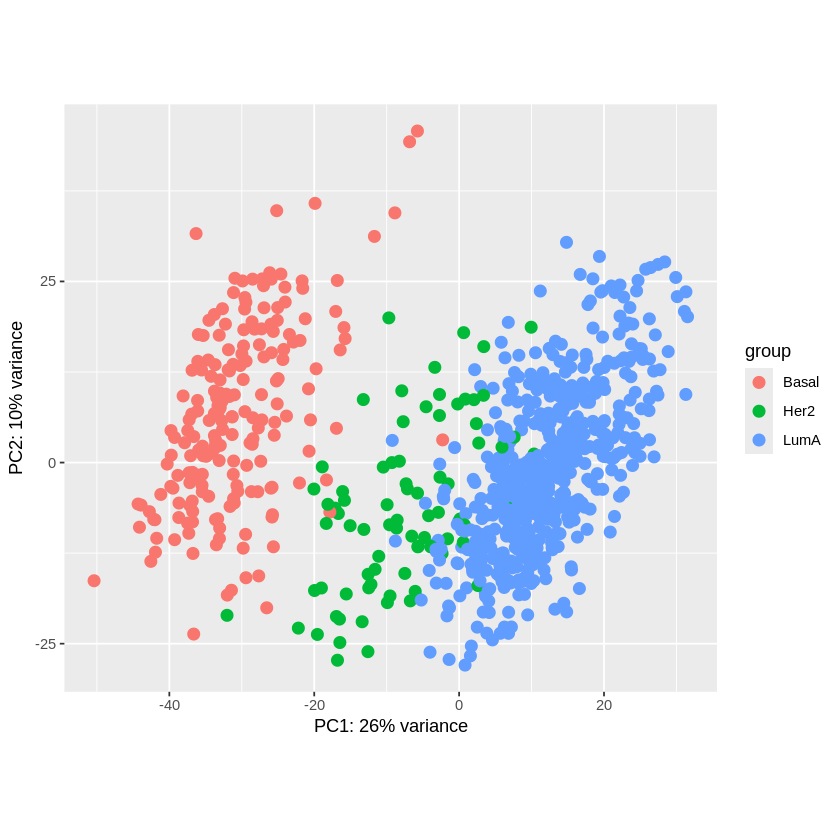

In [20]:
# ==============================================================================
# ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
# ==============================================================================

# El PCA es una técnica de reducción de dimensionalidad que nos permite:
# 1. Visualizar la estructura de los datos en 2D
# 2. Identificar patrones de agrupación entre muestras
# 3. Detectar posibles efectos de batch o outliers
# 4. Evaluar la separación entre grupos experimentales

# PASO 1: TRANSFORMACIÓN DE DATOS PARA VISUALIZACIÓN
# ------------------------------------------------------------------------------
# Usaremos una Variance Stabilizing Transformation (VST)
# La VST es crucial antes del PCA porque:
# - Estabiliza la varianza a lo largo del rango de expresión
# - Reduce la dependencia de la varianza respecto a la media
# - Hace que los datos sean más apropiados para métodos como PCA

# OPCIÓN 1: Calcular VST (comentado por ser computacionalmente intensivo)
# vst_counts <- vst(dds)
#
# LA FUNCIÓN vst() REALIZA:
# - Transformación que estabiliza la varianza
# - Ajuste de un modelo para la relación media-varianza
# - Aplicación de una transformación log-like que es menos sensible a outliers
# - Regularización para genes con baja expresión

# OPCIÓN 2: Cargar VST pre-calculado
vst_counts <- readRDS("vst.rds")

# PASO 2: ANÁLISIS PCA POR SUBTIPOS DE CÁNCER
# ------------------------------------------------------------------------------
# Veamos primero por subtipos (variable principal de interés)
pca_condicion <- plotPCA(
  vst_counts,
  intgroup = "condition",
  ntop = 200
)

# EXPLICACIÓN DE LOS PARÁMETROS:
# - vst_counts: Objeto DESeq2 con datos transformados
# - intgroup = "condition":
#   * Especifica qué variable usar para colorear los puntos
#   * "condition" corresponde a los subtipos PAM50 de cáncer de mama
#   * Los puntos se colorearán según: Luminal A, HER2+ y Basal
# - ntop = 200:
#   * Selecciona los 200 genes con mayor varianza entre muestras
#   * Usar solo los genes más variables mejora la señal vs ruido

# PASO 3: VISUALIZACIÓN DEL PCA
# ------------------------------------------------------------------------------
# Mostrar el gráfico en la consola/panel de gráficos
pca_condicion

# QUÉ ESPERAR EN EL GRÁFICO:
# - Eje X: Primera componente principal (PC1) - mayor fuente de variación
# - Eje Y: Segunda componente principal (PC2) - segunda mayor fuente de variación
# - Puntos coloreados según subtipo PAM50
# - % de varianza explicada por cada componente en los ejes
# - Agrupación de muestras del mismo subtipo indica buena separación biológica

# INTERPRETACIÓN TÍPICA:
# - Subtipos bien definidos deberían formar clusters separados
# - Luminal-A y Basal deberían separarse claramente (perfil muy diferente)
# - HER2+ puede formar un cluster intermedio

# PASO 4: GUARDAR EL GRÁFICO
# ------------------------------------------------------------------------------
ggsave(
  filename = "plots/01-pca_condicion.png",
  plot = pca_condicion,
  dpi = 300,
  width = 8,
  height = 8
)

# EXPLICACIÓN DE LOS PARÁMETROS DE GUARDADO:
# - filename:
#   * Especifica la carpeta "plots/" y nombre descriptivo
#   * Extensión .png para formato de imagen común
#   * Prefijo "01-" para mantener orden en análisis secuencial
# - plot = pca_condicion:
#   * Objeto ggplot2 que contiene el gráfico PCA
#   * Si se omite, ggsave() guardará el último gráfico mostrado
# - dpi = 300:
#   * Alta resolución apropiada para publicaciones
#   * 300 DPI es estándar para figuras científicas
# - width = 8, height = 8:
#   * Dimensiones en pulgadas

using ntop=200 top features by variance



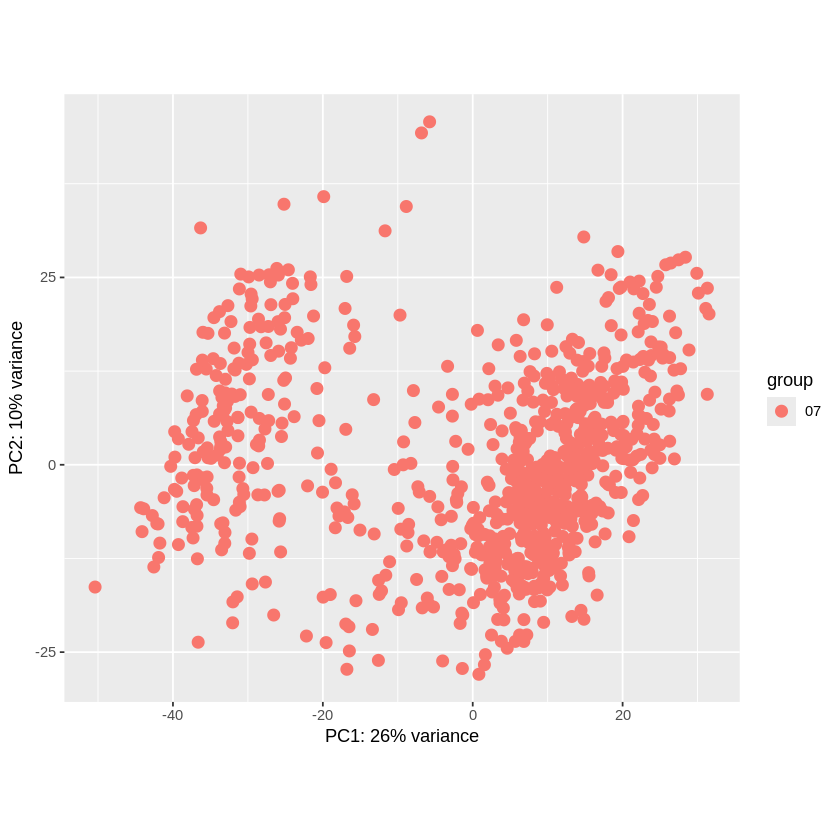

In [21]:
# ==============================================================================
# ANÁLISIS PCA POR FACTOR DE BATCH 1 (CENTRO DE SECUENCIACIÓN)
# ==============================================================================

# PROPÓSITO DEL ANÁLISIS:
# Este análisis es crucial para detectar efectos de batch técnicos que podrían
# confundir nuestros resultados biológicos. El batch1 representa el código del
# centro donde se secuenciaron las muestras.

# PASO 1: GENERACIÓN DEL PCA POR BATCH1
# ------------------------------------------------------------------------------
# Inspeccionemos el batch1 (código del centro de secuenciación)
pca_batch1 <- plotPCA(
  vst_counts,                    # Datos transformados con VST (mismo que antes)
  intgroup = "batch1",           # Variable de agrupación: código del centro de secuenciación
  ntop = 200                     # Usar los 200 genes más variables (consistente con análisis anterior)
)

# EXPLICACIÓN DEL FACTOR BATCH1:
# - batch1: Últimos 2 dígitos del barcode TCGA
# - Representa el código del centro de secuenciación donde se procesó cada muestra
# - Diferentes centros pueden introducir variabilidad técnica debido a:
#   * Diferencias en protocolos de extracción de RNA
#   * Variaciones en equipos de secuenciación
#   * Diferencias en reactivos y kits utilizados
#   * Variabilidad entre técnicos y procedimientos

# POR QUÉ ES IMPORTANTE VERIFICAR BATCH EFFECTS:
# 1. Pueden enmascarar señales biológicas reales
# 2. Pueden crear patrones falsos que parecen biológicamente relevantes
# 3. Afectan la reproducibilidad de los resultados
# 4. Pueden llevar a conclusiones erróneas en análisis diferencial

# PASO 2: VISUALIZACIÓN DEL PCA
# ------------------------------------------------------------------------------
# Mostrar el gráfico para evaluación visual
pca_batch1

# QUÉ BUSCAR EN ESTE GRÁFICO:
#
# ESCENARIO IDEAL (sin batch effects significativos):
# - Los puntos de diferentes colores (centros) están mezclados aleatoriamente
# - No hay agrupación clara por código de centro
# - Los centros están distribuidos uniformemente en el espacio PCA
#
# SEÑALES DE ALERTA (batch effects problemáticos):
# - Agrupación clara de muestras por centro de secuenciación
# - Separación de centros a lo largo de PC1 o PC2
# - Un centro forma un cluster aislado del resto
# - Gradientes evidentes relacionados con códigos de centro


# PASO 3: GUARDAR EL GRÁFICO PARA DOCUMENTACIÓN
# ------------------------------------------------------------------------------
ggsave(
  filename = "plots/02-pca_batch1.png",  # Nombre descriptivo con numeración secuencial
  plot = pca_batch1,                     # Objeto del gráfico PCA por batch1
  dpi = 300,                             # Alta resolución para análisis detallado
  width = 8,                             # Dimensiones cuadradas para comparación
  height = 8                             # con el gráfico anterior (01-pca_condicion.png)
)


# CONSIDERACIONES PARA LA INTERPRETACIÓN:
# ------------------------------------------------------------------------------
#
# COMPARACIÓN CON PCA BIOLÓGICO:
#    - Compare este gráfico con "01-pca_condicion.png"
#    - ¿El patrón de batch es más fuerte que el patrón biológico?
#    - ¿Los batch effects pueden estar confundidos con subtipos?

# ACCIONES RECOMENDADAS SEGÚN RESULTADOS:
# ------------------------------------------------------------------------------
#
# SI NO HAY BATCH EFFECTS EVIDENTES:
# - Continuar con análisis sin corrección adicional
# - Documentar que se verificó la ausencia de batch effects
#
# SI HAY BATCH EFFECTS MODERADOS:
# - Incluir batch1 en el modelo de DESeq2: design = ~ batch1 + condition
# - Considerar corrección con ComBat-seq o similar
#
# SI HAY BATCH EFFECTS SEVEROS:
# - Aplicar corrección de batch obligatoria antes de análisis
# - Re-evaluar con PCA post-corrección
# - Considerar remover centros problemáticos si tienen pocas muestras

using ntop=200 top features by variance



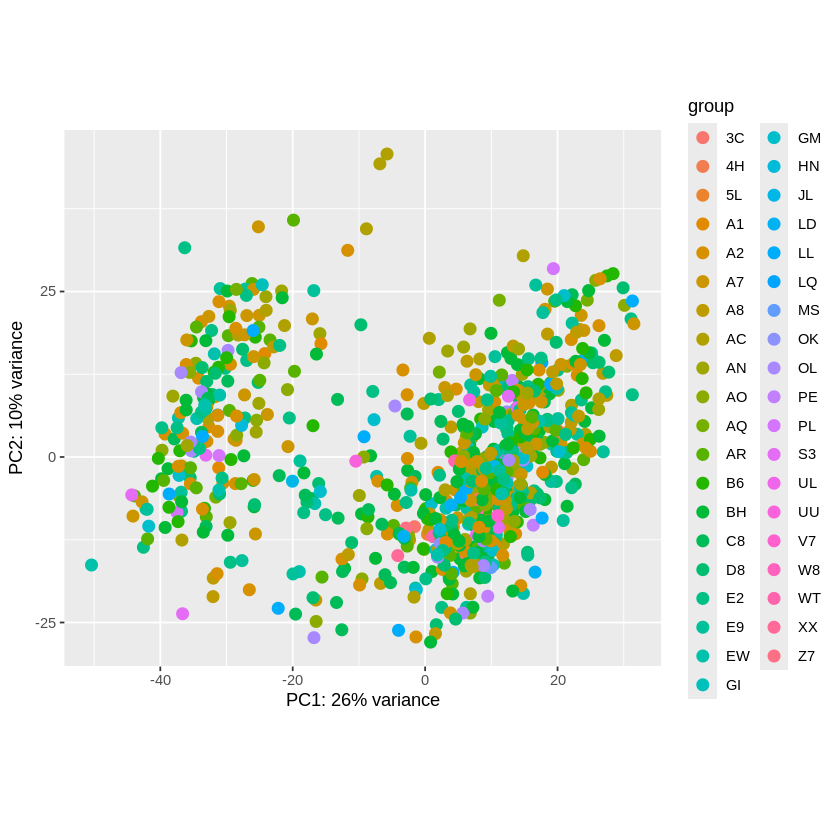

In [22]:
# ==============================================================================
# ANÁLISIS PCA POR FACTOR DE BATCH 2 (POSICIONES 6-7 DEL BARCODE)
# ==============================================================================

# PROPÓSITO DEL ANÁLISIS:
# Continuamos la evaluación sistemática de batch effects analizando batch2,
# que corresponde a los caracteres en las posiciones 6-7 del barcode TCGA.
# El batch2 representa el código del centro donde se tomaron las muestras.

# PASO 1: GENERACIÓN DEL PCA POR BATCH2
# ------------------------------------------------------------------------------
# Inspeccionemos el batch2 (posiciones 6-7 del barcode TCGA)
pca_batch2 <- plotPCA(
  vst_counts,                    # Mismos datos transformados con VST
  intgroup = "batch2",           # Variable de agrupación: caracteres 6-7 del barcode
  ntop = 200                     # Consistencia en número de genes más variables
)

# PASO 2: VISUALIZACIÓN Y EVALUACIÓN
# ------------------------------------------------------------------------------
# Mostrar el gráfico para análisis visual
pca_batch2

# PASO 3: DOCUMENTACIÓN Y ARCHIVO
# ------------------------------------------------------------------------------
ggsave(
  filename = "plots/03-pca_batch2.png",  # Numeración secuencial para orden lógico
  plot = pca_batch2,                     # Gráfico PCA específico para batch2
  dpi = 300,                             # Resolución consistente para comparación
  width = 8,                             # Dimensiones estándar para análisis
  height = 8                             # Facilita comparación side-by-side
)

using ntop=200 top features by variance



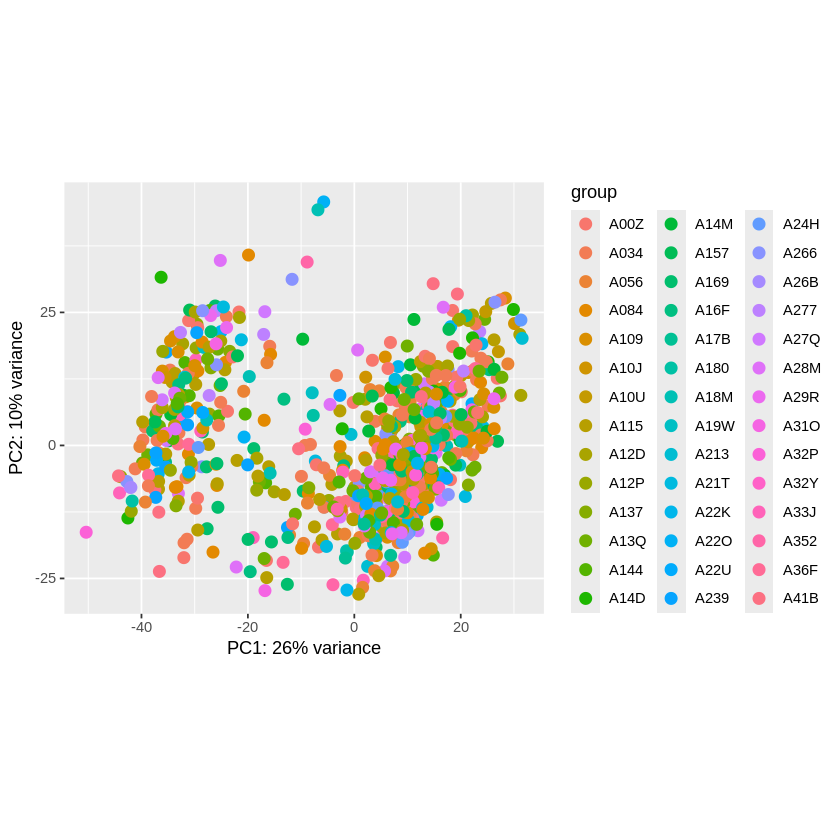

In [23]:
# ==============================================================================
# ANÁLISIS PCA POR FACTOR DE BATCH 3 (POSICIONES 22-25 DEL BARCODE)
# ==============================================================================

# PROPÓSITO DEL ANÁLISIS:
# Continuamos la evaluación sistemática de batch effects analizando batch3,
# que corresponde a los caracteres en las posiciones 22-25 del barcode TCGA.
# El batch3 representa el código de la placa de secuenciación.

# PASO 1: GENERACIÓN DEL PCA POR BATCH3
# ------------------------------------------------------------------------------
# Inspeccionemos el batch3 (posiciones 22-25 del barcode TCGA)
pca_batch3 <- plotPCA(
  vst_counts,                    # Mismos datos transformados con VST
  intgroup = "batch3",           # Variable de agrupación: caracteres 22-25 del barcode
  ntop = 200                     # Consistencia en número de genes más variables
)

# PASO 2: VISUALIZACIÓN Y EVALUACIÓN
# ------------------------------------------------------------------------------
# Mostrar el gráfico para análisis visual
pca_batch3

# PASO 3: DOCUMENTACIÓN Y ARCHIVO
# ------------------------------------------------------------------------------
ggsave(
  filename = "plots/04-pca_batch3.png",  # Numeración secuencial para orden lógico
  plot = pca_batch3,                     # Gráfico PCA específico para batch3
  dpi = 300,                             # Resolución consistente para comparación
  width = 8,                             # Dimensiones estándar para análisis
  height = 8                             # Facilita comparación side-by-side
)

In [24]:
# ==============================================================================
# ANÁLISIS DE EXPRESIÓN DIFERENCIAL CON DESEQ2
# ==============================================================================

# PROPÓSITO DEL ANÁLISIS:
# El análisis diferencial identifica genes que se expresan de manera
# significativamente diferente entre dos o más condiciones experimentales.
# En este caso, comparamos subtipos moleculares de cáncer de mama.

# PASO 1: EXTRACCIÓN DE RESULTADOS DEL ANÁLISIS DIFERENCIAL
# ------------------------------------------------------------------------------
# Realizamos un análisis diferencial utilizando DESeq2.
res <- as.data.frame(results(
  dds, # Objeto DESeq2 previamente procesado
  contrast = c("condition", "LumA", "Basal")  # Especificación del contraste
))  # Para comparar Luminal A vs Basal

# EXPLICACIÓN DETALLADA DE LOS PARÁMETROS:
#
# - dds: Objeto DESeqDataSet que contiene:
#   * Datos de conteos normalizados
#   * Factores de normalización calculados
#   * Estimaciones de dispersión por gen
#   * Modelo estadístico ajustado
#
# - contrast: Vector que especifica la comparación deseada
#   * Formato: c("variable", "numerador", "denominador")
#   * "condition": nombre de la variable en colData (subtipos PAM50)
#   * "LumA": grupo numerador (Luminal A) - grupo de referencia para log2FC
#   * "Basal": grupo denominador (Basal-like) - grupo de comparación
#
# INTERPRETACIÓN DEL CONTRASTE:
# - Log2FoldChange positivo: gen más expresado en Luminal A que Basal
# - Log2FoldChange negativo: gen más expresado en Basal que Luminal A
# - Esta comparación es biológicamente relevante porque:
#   * Luminal A: tumores con buen pronóstico, receptores hormonales positivos
#   * Basal-like: tumores agresivos, triple negativos, peor pronóstico

# PASO 2: VISUALIZACIÓN Y ALMACENAMIENTO DE RESULTADOS
# ------------------------------------------------------------------------------
# Mostrar las primeras filas de los resultados
# y guardar la tabla completa
head(res)
write.csv(res, "TCGA-BRCA_DESeq2_results.csv")

# ESTRUCTURA DE LOS RESULTADOS (COLUMNAS ESPERADAS):
#
# 1. baseMean:
#    - Expresión promedio normalizada del gen a través de todas las muestras
#    - Útil para filtrar genes con expresión muy baja
#    - Valores más altos indican genes con mayor expresión general
#
# 2. log2FoldChange:
#    - Cambio en expresión en escala log2 (LumA vs Basal)
#    - Valores positivos: más expresado en Luminal A
#    - Valores negativos: más expresado en Basal-like
#    - Magnitude: |log2FC| > 1 equivale a cambio > 2x
#
# 3. lfcSE:
#    - Error estándar del log2FoldChange
#    - Medida de incertidumbre en la estimación
#    - Valores menores indican estimaciones más precisas
#
# 4. stat:
#    - Estadístico de prueba (log2FC / lfcSE)
#    - Utilizado para calcular el p-valor
#    - Valores absolutos grandes indican diferencias más significativas
#
# 5. pvalue:
#    - P-valor sin ajustar por múltiples comparaciones
#    - Probabilidad de observar diferencia por azar
#    - Valores < 0.05 tradicionalmente considerados significativos
#
# 6. padj:
#    - P-valor ajustado por múltiples comparaciones (método Benjamini-Hochberg)
#    - Controla la tasa de falsos descubrimientos (FDR)
#    - Más conservador que pvalue, recomendado para decisiones finales

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,14.813276,0.6685324,0.07657783,8.730104,2.544391e-18,6.543775e-18
A1BG-AS1,90.383799,0.7452598,0.05750783,12.959275,2.082051e-38,9.616143e-38
A1CF,4.897764,-0.9059173,0.18535987,-4.887343,1.022058e-06,1.643454e-06
A2M,40010.090218,-0.7711629,0.08189050,-9.417001,4.641549e-21,1.306046e-20
A2M-AS1,71.103646,-0.4602760,0.06321422,-7.281209,3.308419e-13,7.066113e-13
A2ML1,1129.264058,-6.5379073,0.15935741,-41.026691,0.000000e+00,0.000000e+00


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


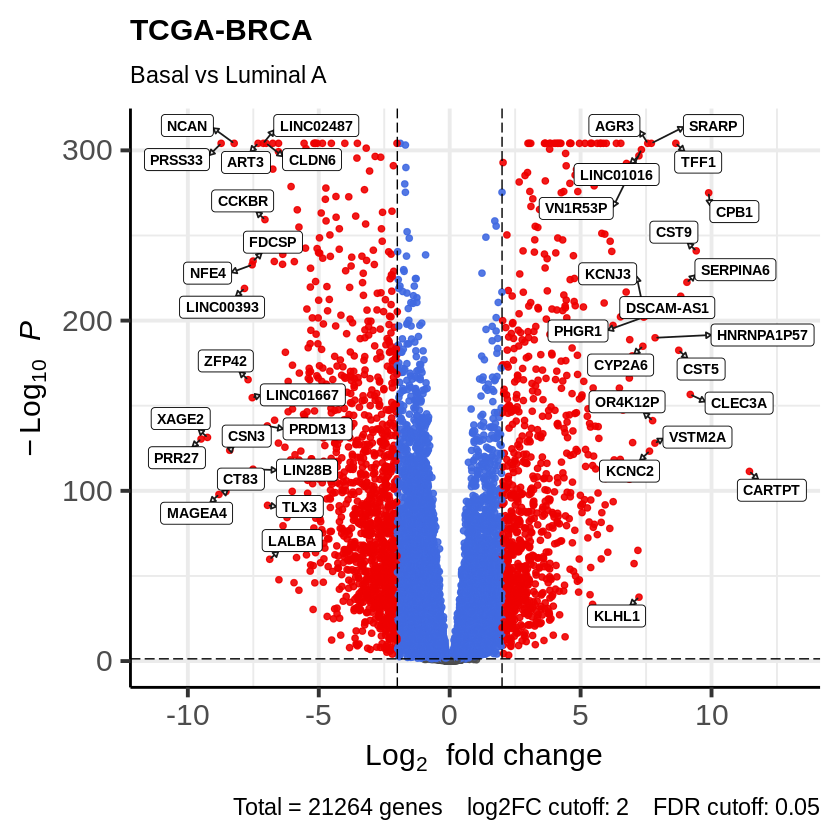

In [25]:
# =============================================================================
# CREACIÓN DE GRÁFICO DE VOLCÁN PARA ANÁLISIS DE EXPRESIÓN DIFERENCIAL
# =============================================================================
# Este código genera un gráfico de volcán que visualiza los resultados de un
# análisis de expresión diferencial entre dos condiciones (Basal vs Luminal A)
# utilizando los resultados de DESeq2

# -----------------------------------------------------------------------------
# SELECCIÓN DE GENES MÁS RELEVANTES PARA ETIQUETADO
# -----------------------------------------------------------------------------

# Seleccionar los 20 genes con mayor log2FC (sobreexpresados en la condición LumA)
# Estos genes muestran el mayor aumento en expresión en la condición tratada vs control
top_up_genes <- head(res[order(res$log2FoldChange, decreasing = TRUE), ], 20)

# Seleccionar los 20 genes con menor log2FC (sobrexpresados en la condición Basal)
top_down_genes <- head(res[order(res$log2FoldChange, decreasing = FALSE), ], 20)

# Unir los nombres de los genes más sobreexpresados y subexpresados para etiquetarlos en el plot
# Se usa unique() para eliminar posibles duplicados entre las dos listas
selected_labels <- unique(c(rownames(top_up_genes), rownames(top_down_genes)))

# -----------------------------------------------------------------------------
# CREACIÓN DEL GRÁFICO DE VOLCÁN
# -----------------------------------------------------------------------------

# Crear el gráfico de volcano utilizando la librería EnhancedVolcano
volcano1 <- EnhancedVolcano(
  # DATOS DE ENTRADA
  res,                     # Objeto con los resultados de DESeq2 (dataframe)
  lab = rownames(res),     # Etiquetas que se mostrarán (nombres de los genes como IDs de fila)
  x = 'log2FoldChange',    # Variable para eje X: cambio en la expresión en escala log2
  y = 'padj',              # Variable para eje Y: valor de p ajustado por FDR (False Discovery Rate)

  # UMBRALES DE SIGNIFICANCIA
  pCutoff = 0.05,          # Límite de significancia estadística (p-valor ajustado)
  FCcutoff = 2,            # Límite de cambio de expresión (|log2FC| > 2, equivale a 4x cambio)

  # CONFIGURACIÓN ESTÉTICA DE LOS PUNTOS
  pointSize = 1.5,         # Tamaño de los puntos en el gráfico (en unidades ggplot)
  labSize = 3,             # Tamaño de fuente de las etiquetas de genes
  labCol = 'black',        # Color del texto de las etiquetas
  labFace = 'bold',        # Estilo de fuente de las etiquetas (negrita)

  # CONFIGURACIÓN DE LAS ETIQUETAS
  boxedLabels = TRUE,             # Mostrar etiquetas dentro de cajas para mejor legibilidad
  maxoverlapsConnectors = Inf,    # Permitir todos los conectores posibles (sin límite de superposición)
  drawConnectors = TRUE,          # Dibujar líneas que conecten las etiquetas con los puntos
  widthConnectors = 0.5,          # Grosor de las líneas conectores

  # ESQUEMA DE COLORES
  # Vector de 4 colores que representa: [No significativo, Solo logFC significativo, Solo p significativo, Ambos significativos]
  col = c('grey30', 'forestgreen', 'royalblue', 'red2'),
  colAlpha = 0.9,              # Nivel de transparencia de los puntos (0=transparente, 1=opaco)

  # CONFIGURACIÓN DE TÍTULOS Y LEYENDA
  legendPosition = "none",     # Ocultar leyenda del gráfico
  title = 'TCGA-BRCA',         # Título principal del gráfico (dataset utilizado)
  subtitle = 'Basal vs Luminal A',  # Subtítulo indicando la comparación realizada

  # PIE DE FIGURA CON INFORMACIÓN RESUMIDA
  caption = paste0('Total = ', nrow(res),                    # Número total de genes analizados
                   ' genes    log2FC cutoff: 2    FDR cutoff: 0.05'),  # Umbrales utilizados

  # SELECCIÓN DE GENES A ETIQUETAR
  # Solo se etiquetarán los genes previamente seleccionados (top up/down regulados)
  selectLab = selected_labels
)

# Mostrar el gráfico generado
volcano1

# -----------------------------------------------------------------------------
# GUARDADO DEL GRÁFICO
# -----------------------------------------------------------------------------

# Guardar el gráfico en un archivo PNG de alta resolución
ggsave(
  filename = "plots/05-EnhancedVolcano_LumAvsBasal.png",  # Ruta y nombre del archivo de salida
  plot = volcano1,                  # Objeto del gráfico generado previamente
  dpi = 300,                        # Resolución en DPI (puntos por pulgada) - alta calidad para publicación
  width = 8,                       # Ancho de la imagen en pulgadas
  height = 8                       # Alto de la imagen en pulgadas (gráfico cuadrado)
)

# =============================================================================
# INTERPRETACIÓN DEL GRÁFICO DE VOLCÁN:
# =============================================================================
# - Eje X (log2FoldChange): Indica la magnitud del cambio de expresión
#   * Valores positivos: genes sobreexpresados en condición Luminal A
#   * Valores negativos: genes sobreexpresados en condición Basal
# - Eje Y (-log10(padj)): Indica la significancia estadística
#   * Valores más altos: mayor significancia estadística
# - Colores de los puntos:
#   * Azul: genes con p-valor significativo pero cambio no significativo
#   * Rojo: genes significativos tanto en cambio como en p-valor (los más importantes)
# =============================================================================

In [26]:
# =============================================================================
# CREACIÓN DE GRÁFICOS DE CAJAS PARA GENES MARCADORES ESPECÍFICOS
# =============================================================================
# Este código genera gráficos de cajas (boxplots) para visualizar la expresión
# de genes marcadores específicos entre diferentes subtipos de cáncer de mama

# -----------------------------------------------------------------------------
# EXTRACCIÓN DE DATOS DE EXPRESIÓN NORMALIZADOS
# -----------------------------------------------------------------------------

# Extraer la matriz de expresión normalizada con transformación VST
# VST es una transformación que estabiliza la varianza y es apropiada para visualización
mat_vst <- assay(vst_counts)

# Extraer expresión del gen PGR (Receptor de Progesterona)
# PGR es un marcador característico del subtipo Luminal A de cáncer de mama
expr_PGR <- as.numeric(mat_vst["PGR", ])    # Convertir a vector numérico para facilitar manipulación

# Extraer expresión del gen ERBB2 (también conocido como HER2)
# ERBB2/HER2 es un marcador característico del subtipo HER2-positivo de cáncer de mama
expr_ERBB2 <- as.numeric(mat_vst["ERBB2", ]) # Convertir a vector numérico para facilitar manipulación

# Extraer expresión del gen KRT5 (Keratina 5)
# KRT5 es un marcador característico del subtipo Basal-like de cáncer de mama
expr_KRT5 <- as.numeric(mat_vst["KRT5", ]) # Convertir a vector numérico para facilitar manipulación

# -----------------------------------------------------------------------------
# PREPARACIÓN DE METADATOS Y FACTORIZACIÓN
# -----------------------------------------------------------------------------

# Convertir la columna 'condition' en factor con niveles ordenados específicamente
# Esto asegura que los grupos aparezcan en el orden deseado en los gráficos
col_data$condition <- factor(col_data$condition,
                             levels = c("LumA",    # Luminal A (receptor hormonal positivo)
                                       "Her2",     # HER2-positivo (sobreexpresión de ERBB2)
                                       "Basal"))   # Basal-like (triple negativo)

# -----------------------------------------------------------------------------
# CONSTRUCCIÓN DE DATA.FRAMES PARA VISUALIZACIÓN
# -----------------------------------------------------------------------------

# Crear data.frame para el gen PGR
# Es crucial alinear correctamente las muestras entre expresión y metadatos
df <- data.frame(
  PGR       = expr_PGR,                                    # Valores de expresión del gen PGR
  condition = col_data[colnames(mat_vst), "condition"]     # Condiciones alineadas por nombre de muestra
)
# Nota: col_data[colnames(mat_vst), "condition"] asegura que el orden de las condiciones
#       coincida exactamente con el orden de las columnas en la matriz de expresión

# Crear data.frame para el gen ERBB2 (HER2)
# Seguimos la misma estrategia de alineación para mantener consistencia
df2 <- data.frame(
  ERBB2     = expr_ERBB2,                                  # Valores de expresión del gen ERBB2
  condition = col_data[colnames(mat_vst), "condition"]     # Condiciones alineadas por nombre de muestra
)

# Crear data.frame para el gen KRT5
# Seguimos la misma estrategia de alineación para mantener consistencia
df3 <- data.frame(
  KRT5     = expr_KRT5,                                  # Valores de expresión del gen KRT5
  condition = col_data[colnames(mat_vst), "condition"]     # Condiciones alineadas por nombre de muestra
)

# -----------------------------------------------------------------------------
# DEFINICIÓN DE COMPARACIONES ESTADÍSTICAS
# -----------------------------------------------------------------------------

# Definir todas las comparaciones por pares entre los tres subtipos
# Estas comparaciones se utilizarán para pruebas estadísticas (ej: test de Wilcoxon, t-test)
mis_comparaciones <- list(
  c("LumA", "Her2"),    # Comparación: Luminal A vs HER2-positivo
  c("LumA", "Basal"),   # Comparación: Luminal A vs Basal-like
  c("Her2", "Basal")    # Comparación: HER2-positivo vs Basal-like
)

# =============================================================================
# INFORMACIÓN ADICIONAL SOBRE LOS GENES MARCADORES:
# =============================================================================
#
# PGR (Receptor de Progesterona):
# - Marcador del subtipo Luminal A
# - Se espera alta expresión en tumores Luminal A
# - Baja expresión en tumores Basal-like y variable en HER2+
#
# ERBB2 (HER2):
# - Marcador del subtipo HER2-positivo
# - Se espera alta expresión en tumores HER2+
# - Baja expresión en tumores Luminal A y Basal-like
#
# KRT5:
# - Marcador del subtipo Basal-like
# - Se espera alta expresión en tumores Basal-like
# - Baja expresión en tumores Luminal A y HER2+
#
# PRÓXIMOS PASOS TÍPICOS:
# - Crear boxplots usando ggplot2 con los data.frames df, df2 y df3
# - Añadir pruebas estadísticas usando ggpubr::stat_compare_means()
# - Personalizar colores según subtipo molecular
# =============================================================================

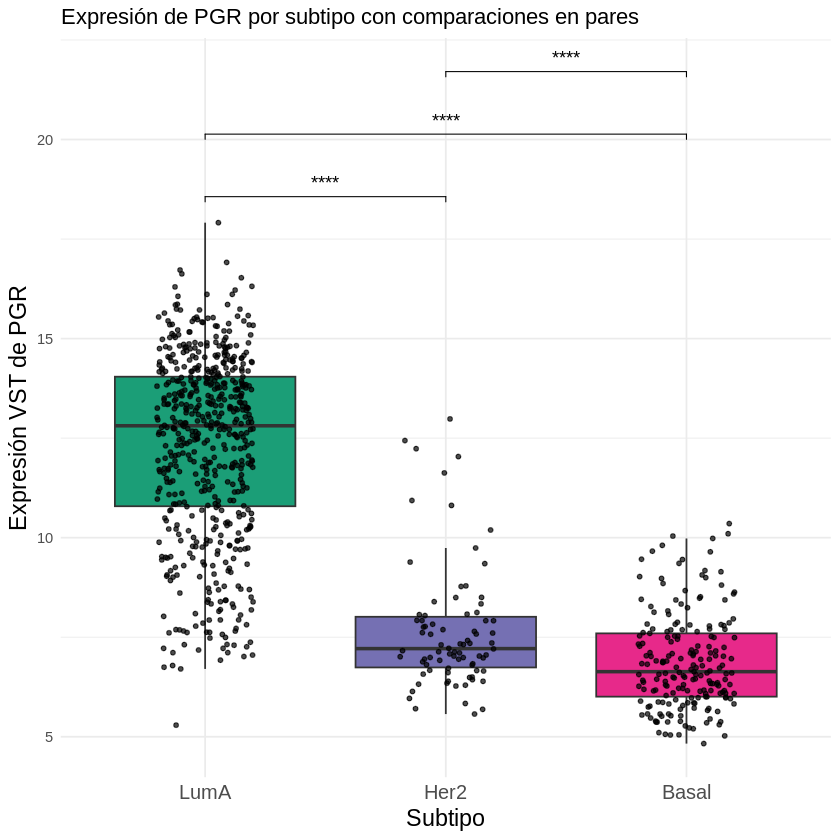

In [27]:
# =============================================================================
# CREACIÓN DE GRÁFICO DE CAJAS PARA EL GEN PGR (RECEPTOR DE PROGESTERONA)
# =============================================================================
# Este código genera un boxplot que muestra la distribución de expresión del gen PGR
# entre los diferentes subtipos moleculares de cáncer de mama, incluyendo comparaciones
# estadísticas por pares utilizando la prueba de Wilcoxon

# -----------------------------------------------------------------------------
# CONSTRUCCIÓN DEL GRÁFICO DE CAJAS
# -----------------------------------------------------------------------------

boxplot_pgr <- ggplot(df, aes(x = condition, y = PGR, fill = condition)) +

  # CAPA BASE: BOXPLOT
  geom_boxplot(outlier.shape = NA) +    # Crear cajas sin mostrar outliers (se muestran con jitter)
  # outlier.shape = NA evita la duplicación de puntos outliers que se mostrarán con geom_jitter

  # CAPA DE PUNTOS: MOSTRAR TODAS LAS OBSERVACIONES INDIVIDUALES
  geom_jitter(width = 0.2,              # Dispersión horizontal de los puntos (evita superposición)
              size = 1,                  # Tamaño de los puntos individuales
              alpha = 0.7) +             # Transparencia de los puntos (0=transparente, 1=opaco)

  # ESQUEMA DE COLORES PERSONALIZADO
  # Colores distintivos para cada subtipo molecular de cáncer de mama
  scale_fill_manual(values = c(
    LumA = "#1b9e77",    # Verde para Luminal A (se espera alta expresión de PGR)
    Her2 = "#7570b3",    # Púrpura para HER2-positivo (expresión variable de PGR)
    Basal = "#e7298a"    # Rosa/magenta para Basal-like (se espera baja expresión de PGR)
  )) +

  # ANÁLISIS ESTADÍSTICO: COMPARACIONES POR PARES
  stat_compare_means(
    comparisons = mis_comparaciones,     # Lista de comparaciones definida previamente
    method = "wilcox.test",              # Prueba de Wilcoxon (no paramétrica, apropiada para datos de expresión)
    label = "p.signif",                  # Mostrar significancia como símbolos (*, **, *** en lugar de valores numéricos)
    tip.length = 0.01,                   # Longitud de las líneas verticales de los brackets de comparación
    label.size = 5                       # Tamaño de fuente de las etiquetas de significancia
  ) +

  # ETIQUETAS Y TÍTULOS
  labs(
    title = "Expresión de PGR por subtipo con comparaciones en pares",  # Título principal
    x = "Subtipo",                       # Etiqueta del eje X
    y = "Expresión VST de PGR"          # Etiqueta del eje Y (VST = Variance Stabilizing Transformation)
  ) +

  # TEMA Y ESTILO VISUAL
  theme_minimal() +                      # Tema minimalista y limpio
  theme(
    legend.position = "none",            # Ocultar leyenda (los colores son autodescriptivos)
    axis.text.x = element_text(size = 12),      # Tamaño de fuente para etiquetas del eje X
    axis.title = element_text(size = 14)        # Tamaño de fuente para títulos de ejes
  )

# Mostrar el gráfico generado
boxplot_pgr

# -----------------------------------------------------------------------------
# GUARDADO DEL GRÁFICO EN ARCHIVO
# -----------------------------------------------------------------------------

# Guardar el gráfico en formato PNG de alta resolución
ggsave(
  filename = "plots/06-boxplot_pgr.png",    # Ruta y nombre del archivo de salida
  plot = boxplot_pgr,                       # Objeto del gráfico generado previamente
  dpi = 300,                                # Resolución en DPI (puntos por pulgada) - calidad de publicación
  width = 6,                                # Ancho de la imagen en pulgadas
  height = 6                                # Alto de la imagen en pulgadas (formato cuadrado)
)

# =============================================================================
# INTERPRETACIÓN BIOLÓGICA ESPERADA DEL GRÁFICO:
# =============================================================================
#
#
# PATRONES ESPERADOS:
# - Luminal A (LumA): ALTA expresión de PGR
#   * Estos tumores son receptor hormonal positivos
#   * Responden bien a terapia hormonal

# SÍMBOLOS DE SIGNIFICANCIA:
# - ns: no significativo (p > 0.05)
# - *: p ≤ 0.05
# - **: p ≤ 0.01
# - ***: p ≤ 0.001
# - ****: p ≤ 0.0001
# =============================================================================

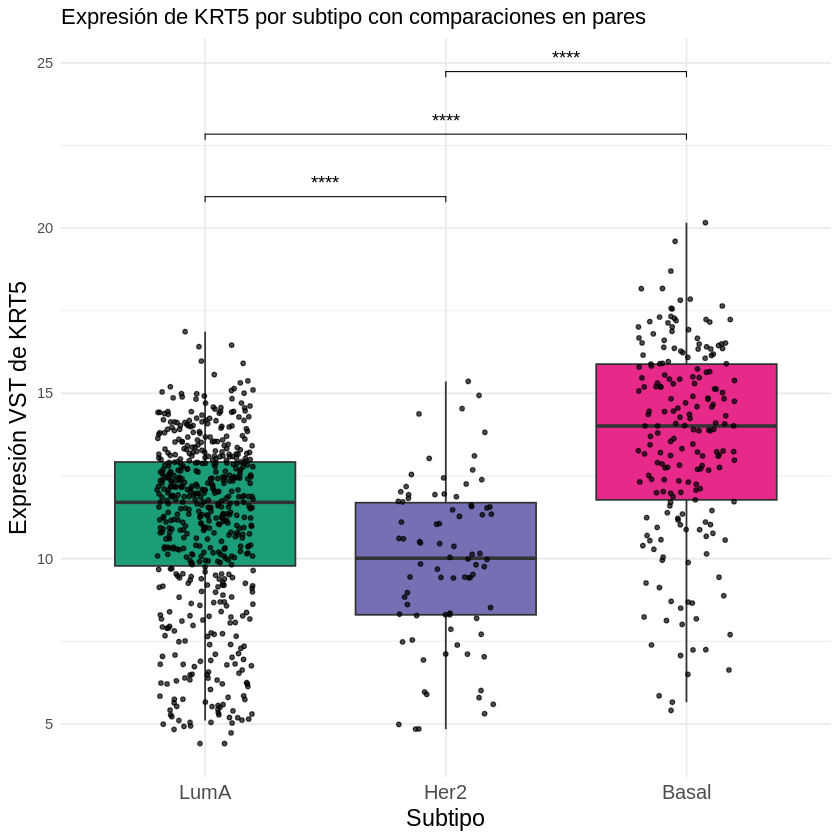

In [28]:
# =============================================================================
# CREACIÓN DE GRÁFICO DE CAJAS PARA EL GEN KRT5 (Keratina 5)
# =============================================================================
# Este código genera un boxplot que muestra la distribución de expresión del gen KRT5
# entre los diferentes subtipos moleculares de cáncer de mama, incluyendo comparaciones
# estadísticas por pares utilizando la prueba de Wilcoxon

# -----------------------------------------------------------------------------
# CONSTRUCCIÓN DEL GRÁFICO DE CAJAS
# -----------------------------------------------------------------------------

boxplot_KRT5 <- ggplot(df3, aes(x = condition, y = KRT5, fill = condition)) +

  # CAPA BASE: BOXPLOT
  geom_boxplot(outlier.shape = NA) +    # Crear cajas sin mostrar outliers (se muestran con jitter)
  # outlier.shape = NA evita la duplicación de puntos outliers que se mostrarán con geom_jitter

  # CAPA DE PUNTOS: MOSTRAR TODAS LAS OBSERVACIONES INDIVIDUALES
  geom_jitter(width = 0.2,              # Dispersión horizontal de los puntos (evita superposición)
              size = 1,                  # Tamaño de los puntos individuales
              alpha = 0.7) +             # Transparencia de los puntos (0=transparente, 1=opaco)

  # ESQUEMA DE COLORES PERSONALIZADO
  # Colores distintivos para cada subtipo molecular de cáncer de mama
  scale_fill_manual(values = c(
    LumA = "#1b9e77",    # Verde para Luminal A (se espera alta expresión de KRT5)
    Her2 = "#7570b3",    # Púrpura para HER2-positivo (expresión variable de KRT5)
    Basal = "#e7298a"    # Rosa/magenta para Basal-like (se espera baja expresión de KRT5)
  )) +

  # ANÁLISIS ESTADÍSTICO: COMPARACIONES POR PARES
  stat_compare_means(
    comparisons = mis_comparaciones,     # Lista de comparaciones definida previamente
    method = "wilcox.test",              # Prueba de Wilcoxon (no paramétrica, apropiada para datos de expresión)
    label = "p.signif",                  # Mostrar significancia como símbolos (*, **, *** en lugar de valores numéricos)
    tip.length = 0.01,                   # Longitud de las líneas verticales de los brackets de comparación
    label.size = 5                       # Tamaño de fuente de las etiquetas de significancia
  ) +

  # ETIQUETAS Y TÍTULOS
  labs(
    title = "Expresión de KRT5 por subtipo con comparaciones en pares",  # Título principal
    x = "Subtipo",                       # Etiqueta del eje X
    y = "Expresión VST de KRT5"          # Etiqueta del eje Y (VST = Variance Stabilizing Transformation)
  ) +

  # TEMA Y ESTILO VISUAL
  theme_minimal() +                      # Tema minimalista y limpio
  theme(
    legend.position = "none",            # Ocultar leyenda (los colores son autodescriptivos)
    axis.text.x = element_text(size = 12),      # Tamaño de fuente para etiquetas del eje X
    axis.title = element_text(size = 14)        # Tamaño de fuente para títulos de ejes
  )

# Mostrar el gráfico generado
boxplot_KRT5

# -----------------------------------------------------------------------------
# GUARDADO DEL GRÁFICO EN ARCHIVO
# -----------------------------------------------------------------------------

# Guardar el gráfico en formato PNG de alta resolución
ggsave(
  filename = "plots/07-boxplot_krt5.png",   # Ruta y nombre del archivo de salida
  plot = boxplot_KRT5,                       # Objeto del gráfico generado previamente
  dpi = 300,                                # Resolución en DPI (puntos por pulgada) - calidad de publicación
  width = 6,                                # Ancho de la imagen en pulgadas
  height = 6                                # Alto de la imagen en pulgadas (formato cuadrado)
)

# =============================================================================
# INTERPRETACIÓN BIOLÓGICA ESPERADA DEL GRÁFICO:
# =============================================================================
#
#
# PATRONES ESPERADOS:
# - Basal-like: ALTA expresión de KRT5
#   * Estos tumores son receptor hormonal negativos
#   * No responden a terapia hormonal

# SÍMBOLOS DE SIGNIFICANCIA:
# - ns: no significativo (p > 0.05)
# - *: p ≤ 0.05
# - **: p ≤ 0.01
# - ***: p ≤ 0.001
# - ****: p ≤ 0.0001
# =============================================================================

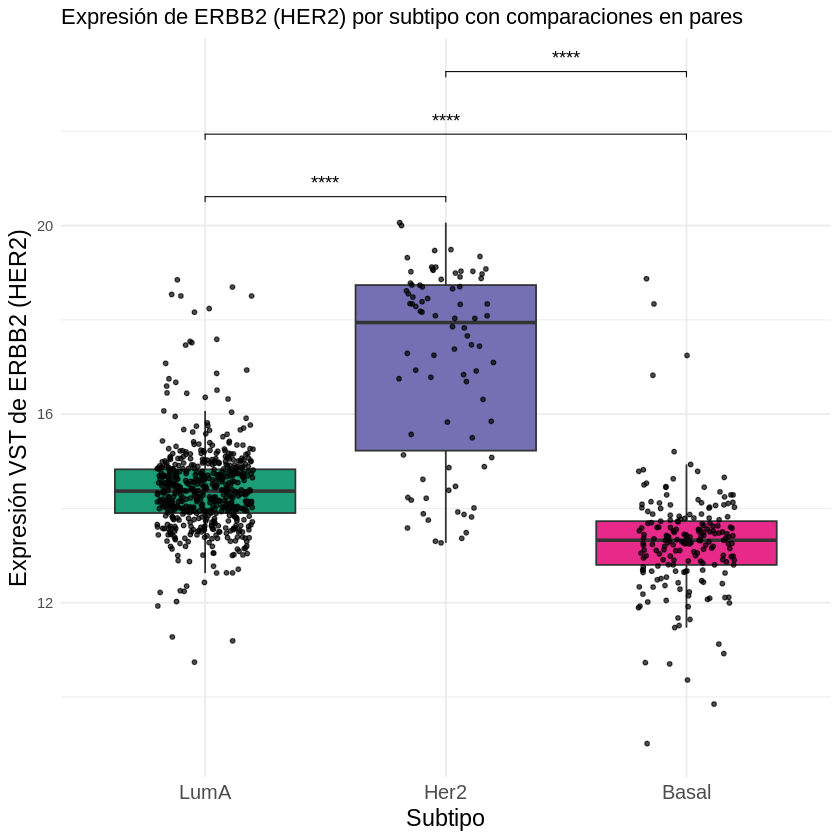

In [29]:
# =============================================================================
# CREACIÓN DE GRÁFICO DE CAJAS PARA EL GEN ERBB2 (HER2)
# =============================================================================
# Este código genera un boxplot que muestra la distribución de expresión del gen ERBB2
# (también conocido como HER2) entre los diferentes subtipos moleculares de cáncer de mama,
# incluyendo comparaciones estadísticas por pares utilizando la prueba de Wilcoxon

# -----------------------------------------------------------------------------
# CONSTRUCCIÓN DEL GRÁFICO DE CAJAS PARA ERBB2
# -----------------------------------------------------------------------------

boxplot_erbb2 <- ggplot(df2, aes(x = condition, y = ERBB2, fill = condition)) +

  # CAPA BASE: BOXPLOT
  geom_boxplot(outlier.shape = NA) +    # Crear cajas sin mostrar outliers (se evita duplicación con jitter)

  # CAPA DE PUNTOS: VISUALIZAR TODAS LAS OBSERVACIONES INDIVIDUALES
  geom_jitter(width = 0.2,              # Dispersión horizontal para evitar superposición de puntos
              size = 1,                 # Tamaño de los puntos individuales
              alpha = 0.7) +            # Transparencia de los puntos (permite ver densidad)

  # ESQUEMA DE COLORES PERSONALIZADO
  # Mantenemos los mismos colores que en el gráfico de PGR para consistencia visual
  scale_fill_manual(values = c(
    LumA = "#1b9e77",    # Verde para Luminal A (se espera baja expresión de ERBB2)
    Her2 = "#7570b3",    # Púrpura para HER2-positivo (se espera ALTA expresión de ERBB2)
    Basal = "#e7298a"    # Rosa/magenta para Basal-like (se espera baja expresión de ERBB2)
  )) +

  # ANÁLISIS ESTADÍSTICO: COMPARACIONES POR PARES
  stat_compare_means(
    comparisons = mis_comparaciones,     # Lista de comparaciones por pares definida previamente
    method = "wilcox.test",              # Prueba de Wilcoxon-Mann-Whitney (no paramétrica)
    # Wilcoxon es apropiado para datos de expresión génica que pueden no seguir distribución normal
    label = "p.signif",                  # Mostrar significancia como símbolos (*, **, ***) en lugar de p-valores
    tip.length = 0.01,                   # Longitud de las líneas verticales en los brackets de comparación
    label.size = 5                       # Tamaño de fuente de los símbolos de significancia
  ) +

  # ETIQUETAS Y TÍTULOS
  labs(
    title = "Expresión de ERBB2 (HER2) por subtipo con comparaciones en pares",  # Título descriptivo
    x = "Subtipo",                       # Etiqueta del eje X (subtipos moleculares)
    y = "Expresión VST de ERBB2 (HER2)"  # Etiqueta del eje Y (datos transformados con VST)
  ) +

  # CONFIGURACIÓN DE TEMA Y ESTILO
  theme_minimal() +                      # Tema minimalista sin elementos innecesarios
  theme(
    legend.position = "none",            # Ocultar leyenda (colores son autodescriptivos por subtipo)
    axis.text.x = element_text(size = 12),      # Tamaño de fuente para etiquetas de subtipos
    axis.title = element_text(size = 14)        # Tamaño de fuente para títulos de ejes
  )

# Mostrar el gráfico generado en pantalla
boxplot_erbb2

# -----------------------------------------------------------------------------
# EXPORTACIÓN DEL GRÁFICO A ARCHIVO
# -----------------------------------------------------------------------------

# Guardar el gráfico en formato PNG con alta resolución
ggsave(
  filename = "plots/08-boxplot_erbb2.png",     # Ruta y nombre del archivo de salida
  plot = boxplot_erbb2,                        # Objeto del gráfico generado
  dpi = 300,                                   # Resolución en DPI (calidad de publicación científica)
  width = 6,                                   # Ancho de la imagen en pulgadas
  height = 6                                   # Alto de la imagen en pulgadas (formato cuadrado)
)

# =============================================================================
# INTERPRETACIÓN BIOLÓGICA Y CLÍNICA DEL GRÁFICO ERBB2:
# =============================================================================
#
# ERBB2 (también conocido como HER2, neu, o c-erbB-2) es un oncogén crítico:
#
# FUNCIÓN BIOLÓGICA:
# - Codifica un receptor de factor de crecimiento epidérmico
# - Su sobreexpresión/amplificación promueve proliferación celular descontrolada
# - Es tanto un marcador diagnóstico como un objetivo terapéutico
#
# PATRONES DE EXPRESIÓN ESPERADOS:
#
# 1. HER2-positivo (Her2): EXPRESIÓN ALTA
#    * Estos tumores tienen amplificación del gen ERBB2
#    * Definen el subtipo HER2-positivo por definición
#    * Responden a terapias dirigidas (trastuzumab/Herceptin, pertuzumab)


### Análisis de enriquecimiento funcional y correlaciones

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



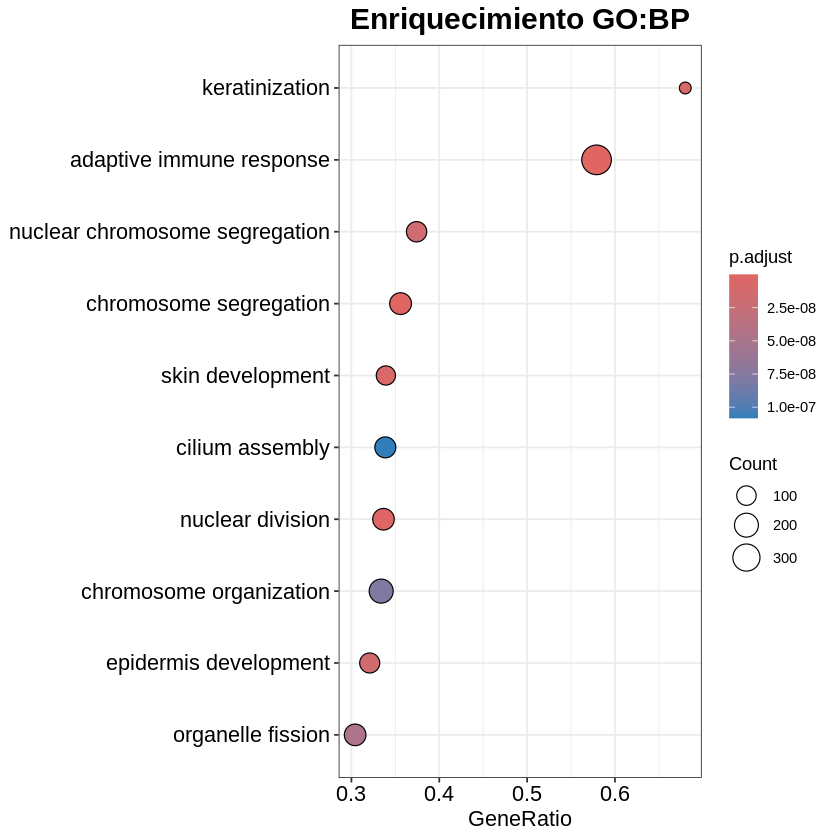

In [30]:
# =============================================================================
# ANÁLISIS DE ENRIQUECIMIENTO FUNCIONAL MEDIANTE GSEA (Gene Set Enrichment Analysis)
# =============================================================================
# Este código realiza un análisis de enriquecimiento de conjuntos de genes utilizando
# Gene Ontology (GO) para identificar procesos biológicos que están significativamente
# enriquecidos en los genes diferencialmente expresados entre condiciones

# -----------------------------------------------------------------------------
# PREPARACIÓN DE DATOS PARA GSEA
# -----------------------------------------------------------------------------

# Extraer los valores de log2FoldChange de los resultados de DESeq2
# Estos valores representan la magnitud y dirección del cambio de expresión
gsea_genes <- res$log2FoldChange

# Asignar nombres de genes a los valores de log2FoldChange
# Los nombres son esenciales para que GSEA pueda mapear genes a conjuntos funcionales
names(gsea_genes) <- rownames(res)

# Ordenar genes por log2FoldChange de mayor a menor
# Este ordenamiento es CRÍTICO para GSEA, ya que el algoritmo evalúa el enriquecimiento
# basándose en la posición de los genes en esta lista ordenada
gsea_genes <- sort(gsea_genes, decreasing = TRUE)

# Especificar la base de datos de anotación para genes humanos
organism = "org.Hs.eg.db"  # Base de datos de Bioconductor para Homo sapiens

# -----------------------------------------------------------------------------
# ANÁLISIS GSEA PARA PROCESOS BIOLÓGICOS DE GENE ONTOLOGY
# -----------------------------------------------------------------------------

gseBP <- gseGO(
  # DATOS DE ENTRADA
  geneList = gsea_genes,        # Lista ordenada de genes con sus estadísticos (log2FC)
  # La lista debe estar ordenada por importancia/magnitud del cambio

  # CONFIGURACIÓN DE GENE ONTOLOGY
  ont = "BP",                   # Ontología GO: "BP" (Biological Process - Procesos Biológicos)
  # Otras opciones: "MF" (Molecular Function), "CC" (Cellular Component)

  # CONFIGURACIÓN DE IDENTIFICADORES
  keyType = "SYMBOL",           # Tipo de identificador de genes usado (símbolos de genes)
  # Alternativas: "ENTREZID", "ENSEMBL", "UNIPROT"

  # FILTROS DE TAMAÑO DE CONJUNTOS DE GENES
  minGSSize = 10,               # Tamaño mínimo de conjunto de genes (evita términos con pocos genes)
  maxGSSize = 1000,             # Tamaño máximo de conjunto de genes (evita términos demasiado generales)
  # Estos filtros ayudan a obtener términos biológicamente interpretables

  # UMBRALES ESTADÍSTICOS
  pvalueCutoff = 0.05,          # Umbral de valor p para considerar enriquecimiento significativo
  eps = 0,                      # Valor epsilon para evitar divisiones por cero en cálculos

  # CORRECCIÓN POR COMPARACIONES MÚLTIPLES
  pAdjustMethod = "BH",         # Método Benjamini-Hochberg para controlar False Discovery Rate
  # Controla la tasa de falsos descubrimientos cuando se prueban múltiples hipótesis

  # BASE DE DATOS Y CONFIGURACIÓN
  OrgDb = organism,             # Base de datos de anotación específica del organismo
  verbose = TRUE                # Mostrar mensajes de progreso durante la ejecución
)

# -----------------------------------------------------------------------------
# VISUALIZACIÓN DE RESULTADOS: DOTPLOT
# -----------------------------------------------------------------------------

bp_plot <- dotplot(gseBP,
  # CONFIGURACIÓN DE CATEGORÍAS A MOSTRAR
  showCategory = 10,            # Mostrar los 10 términos GO más significativos
  # Se ordenan por p-valor ajustado (más significativos primero)

  # CONFIGURACIÓN VISUAL
  color = "p.adjust",           # Codificar color según p-valor ajustado
  # Colores más intensos = mayor significancia estadística
  font.size = 13                # Tamaño de fuente para las etiquetas de términos GO
) +

  # PERSONALIZACIÓN DE TÍTULOS
  labs(title = "Enriquecimiento GO:BP") +  # Título principal del gráfico
  theme(
    plot.title = element_text(
      size = 18,                # Tamaño de fuente del título
      face = "bold",            # Fuente en negrita
      hjust = 0.5               # Centrar título horizontalmente
    )
  )

# Mostrar el gráfico generado
bp_plot

# -----------------------------------------------------------------------------
# EXPORTACIÓN DEL GRÁFICO
# -----------------------------------------------------------------------------

# Guardar el gráfico en formato PNG de alta resolución
ggsave(
  filename = "plots/09-bp_plot.png",       # Ruta y nombre del archivo de salida
  plot = bp_plot,                          # Objeto del gráfico generado
  dpi = 300,                               # Resolución en DPI (calidad de publicación)
  width = 8,                               # Ancho de la imagen en pulgadas
  height = 6                               # Alto de la imagen en pulgadas
)

# =============================================================================
# INTERPRETACIÓN DEL ANÁLISIS GSEA Y DOTPLOT:
# =============================================================================
#
# PRINCIPIO DE GSEA:
# - GSEA evalúa si conjuntos de genes funcionalmente relacionados están
#   enriquecidos en la lista ordenada de genes
#
# ELEMENTOS DEL DOTPLOT:
#
# 1. EJE Y: Términos de Gene Ontology (procesos biológicos)
#    - Ordenados por significancia estadística
#    - Los términos en la parte superior son más significativos
#
# 2. EJE X: Gene Ratio
#    - Proporción de genes en el conjunto que están en nuestra lista
#    - Valores más altos = mayor enriquecimiento
#
# 3. TAMAÑO DEL PUNTO: Número de genes en el conjunto
#    - Puntos más grandes = más genes contribuyen al enriquecimiento
#
# 4. COLOR DEL PUNTO: p-valor ajustado
#    - Colores más intensos/rojizos = mayor significancia
#
# TIPOS DE RESULTADOS ESPERADOS EN CÁNCER:
# - Procesos de proliferación celular (en genes sobreexpresados)
# - Vías de reparación de ADN (en genes subexpresados en tumores agresivos)
# - Procesos de adhesión celular (en genes subexpresados en metástasis)
# - Respuesta inmune (variable según subtipo de cáncer)
# - Metabolismo energético (alterado en células tumorales)
#
# VENTAJAS DE GSEA vs ANÁLISIS DE GENES INDIVIDUALES:
# - Identifica patrones coordinados en vías biológicas
# - Más robusto ante ruido en datos individuales
# - Proporciona interpretación biológica de alto nivel
# - Permite identificar vías sutilmente pero consistentemente alteradas
# =============================================================================

  |======================================================================| 100%



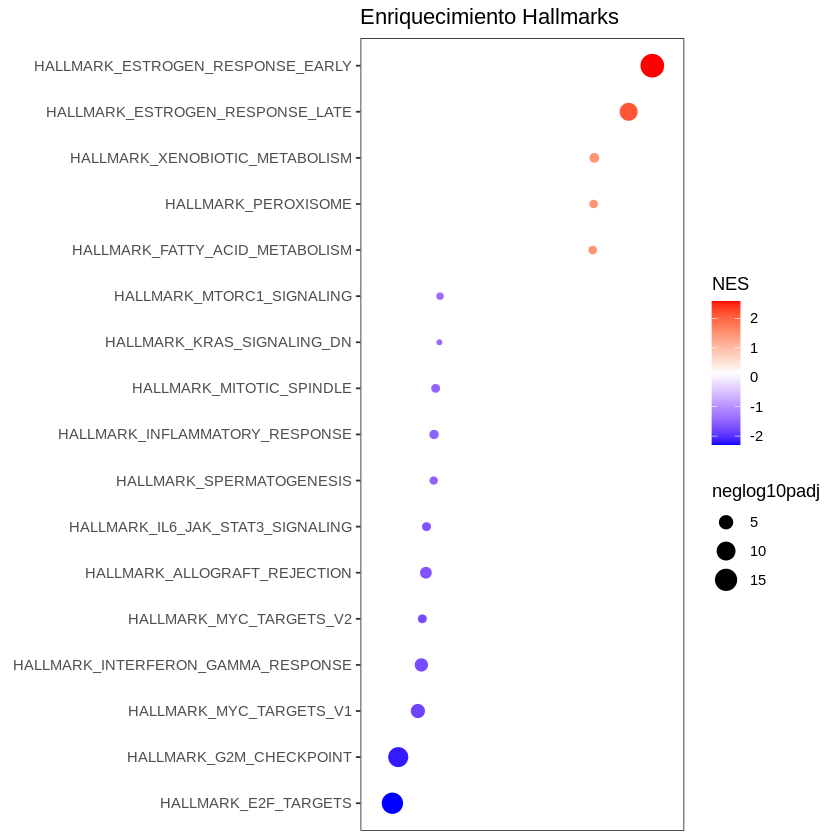

In [31]:
# =============================================================================
# ANÁLISIS GSEA DE HALLMARKS DEL CÁNCER USANDO FGSEA
# =============================================================================
# Este código realiza un análisis de enriquecimiento de conjuntos de genes usando
# los "Hallmarks of Cancer" del Broad Institute/MSigDB, que representan procesos
# biológicos fundamentales alterados en el cáncer

# -----------------------------------------------------------------------------
# PREPARACIÓN Y LECTURA DE ARCHIVO GMT
# -----------------------------------------------------------------------------

# Especificar el archivo GMT que contiene los Hallmarks del cáncer
# GMT = Gene Matrix Transposed, formato estándar para conjuntos de genes
gmt_file <- "h.all.v2024.1.Hs.symbols.gmt"  # Versión 2024.1 de Hallmarks humanos

# Función personalizada para leer archivos GMT y convertirlos a formato de lista
# Los archivos GMT tienen formato: NOMBRE_CONJUNTO\tDESCRIPCIÓN\tGEN1\tGEN2\t...
read_gmt <- function(gmt_path) {
  # Leer todas las líneas del archivo GMT como texto plano
  gmt_lines <- fread(gmt_path, sep = "\n", header = FALSE, data.table = FALSE)[[1]]

  # Procesar cada línea del archivo GMT
  gmt_list <- lapply(gmt_lines, function(line) {
    # Dividir cada línea por tabulaciones
    parts <- strsplit(line, "\t")[[1]]
    setName <- parts[1]           # Primer elemento: nombre del conjunto
    # parts[2] sería la descripción (no la usamos)
    genes <- parts[-c(1,2)]       # Elementos 3 en adelante: genes del conjunto
    return(list(name = setName, genes = genes))
  })

  # Convertir la lista a formato compatible con fgsea
  # Crear lista nombrada donde cada elemento es un vector de genes
  gene_sets <- setNames(lapply(gmt_list, `[[`, "genes"), sapply(gmt_list, `[[`, "name"))
  return(gene_sets)
}

# Leer el archivo GMT y crear la lista de conjuntos de genes
hallmark_list <- read_gmt(gmt_file)

# -----------------------------------------------------------------------------
# ANÁLISIS FGSEA (Fast Gene Set Enrichment Analysis)
# -----------------------------------------------------------------------------

# Ejecutar análisis FGSEA con los Hallmarks del cáncer
GSEAres <- fgsea(
  pathways = hallmark_list,     # Lista de conjuntos de genes (Hallmarks)
  stats = gsea_genes,           # Vector ordenado de genes con estadísticos (log2FC)
  scoreType = 'std',            # Tipo de puntuación: 'std' (estándar), 'pos', 'neg'
  minSize = 10,                 # Tamaño mínimo del conjunto (evita conjuntos muy pequeños)
  maxSize = 500,                # Tamaño máximo del conjunto (evita conjuntos demasiado generales)
  nproc = 1                     # Número de procesadores (1 = secuencial, >1 = paralelo)
)

# -----------------------------------------------------------------------------
# FILTRADO Y PREPARACIÓN DE RESULTADOS
# -----------------------------------------------------------------------------

# Filtrar resultados por significancia estadística
GSEAres_filt <- subset(GSEAres, GSEAres$padj < 0.05)  # Solo conjuntos con FDR < 5%

# Calcular -log10 del p-valor ajustado para visualización
# Valores más altos = mayor significancia estadística
GSEAres_filt$neglog10padj <- -log10(GSEAres_filt$padj)

# Ordenar resultados por NES (Normalized Enrichment Score) de mayor a menor
# NES positivo = enriquecido en genes sobreexpresados
# NES negativo = enriquecido en genes subexpresados
GSEAres_filt <- GSEAres_filt[order(GSEAres_filt$NES, decreasing = TRUE), ]

# Convertir pathway a factor con niveles ordenados (para control del orden en el gráfico)
# rev() invierte el orden para que el mayor NES aparezca arriba en el gráfico
GSEAres_filt$pathway <- factor(GSEAres_filt$pathway, levels = rev(GSEAres_filt$pathway))

# -----------------------------------------------------------------------------
# CREACIÓN DEL GRÁFICO DE ENRIQUECIMIENTO
# -----------------------------------------------------------------------------

GSEA_plot <- ggplot(GSEAres_filt, aes(x = NES, y = pathway)) +

  # PUNTOS PRINCIPALES DEL GRÁFICO
  geom_point(aes(size = neglog10padj,    # Tamaño del punto = significancia estadística
                 color = NES)) +          # Color del punto = dirección y magnitud del enriquecimiento

  # CONFIGURACIÓN DE TEMA BASE
  theme_bw() +                           # Tema con fondo blanco y líneas de cuadrícula
  theme(panel.grid.major = element_line()) +  # Mantener líneas de cuadrícula principales

  # ESCALA DE COLORES
  # Azul = NES negativo (enriquecido en genes subexpresados)
  # Blanco = NES neutro
  # Rojo = NES positivo (enriquecido en genes sobreexpresados)
  scale_color_gradientn(colours = c("blue", "white", "red")) +

  # CONFIGURACIÓN DE EJES
  scale_x_discrete(position = "bottom") + # Posición del eje X en la parte inferior

  # ETIQUETAS Y TÍTULOS
  labs(x = NULL,                         # Sin etiqueta para eje X (se sobreentiende que es NES)
       y = NULL,                         # Sin etiqueta para eje Y (se sobreentiende que son pathways)
       title = "Enriquecimiento Hallmarks") +  # Título principal

  # PERSONALIZACIÓN ADICIONAL DEL TEMA
  theme(panel.grid.major = element_blank(),    # Eliminar líneas de cuadrícula principales
        panel.grid.minor = element_blank())    # Eliminar líneas de cuadrícula menores

# Mostrar el gráfico generado
GSEA_plot

# -----------------------------------------------------------------------------
# EXPORTACIÓN DEL GRÁFICO
# -----------------------------------------------------------------------------

# Guardar el gráfico en formato PNG de alta resolución
ggsave(
  filename = "plots/10-GSEA_plot.png",        # Ruta y nombre del archivo de salida
  plot = GSEA_plot,                           # Objeto del gráfico generado
  dpi = 300,                                  # Resolución en DPI (calidad de publicación)
  width = 6,                                  # Ancho de la imagen en pulgadas
  height = 6                                  # Alto de la imagen en pulgadas
)

# =============================================================================
# INTERPRETACIÓN DE LOS HALLMARKS DEL CÁNCER:
# =============================================================================
#
# Los Hallmarks representan capacidades funcionales adquiridas por las células
# durante el desarrollo tumoral (Hanahan & Weinberg, 2011)
#
# INTERPRETACIÓN DEL GRÁFICO:
#
# EJE X (NES - Normalized Enrichment Score):
# - Valores positivos: Hallmark enriquecido en genes sobreexpresados
# - Valores negativos: Hallmark enriquecido en genes subexpresados
# - Magnitud: Fuerza del enriquecimiento
#
# TAMAÑO DEL PUNTO (-log10 p.adj):
# - Puntos más grandes = mayor significancia estadística
# - Indica confianza en el hallazgo
#
# COLOR DEL PUNTO:
# - Rojo: Hallmarks activados (NES positivo)
# - Azul: Hallmarks reprimidos (NES negativo)
# - Intensidad del color = magnitud del NES

`geom_smooth()` using formula = 'y ~ x'


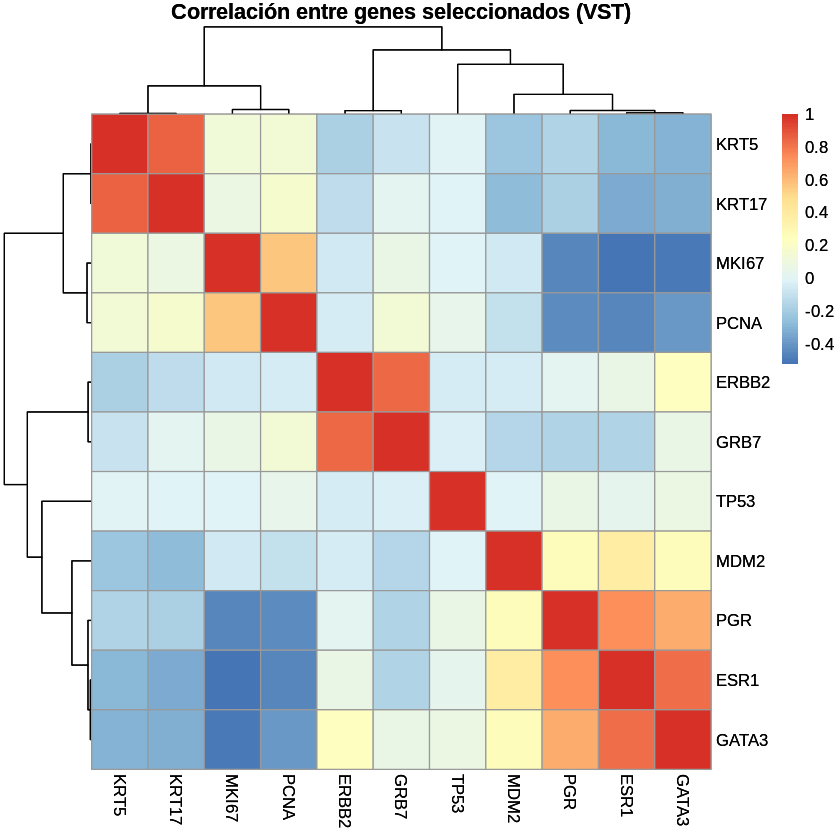

`geom_smooth()` using formula = 'y ~ x'


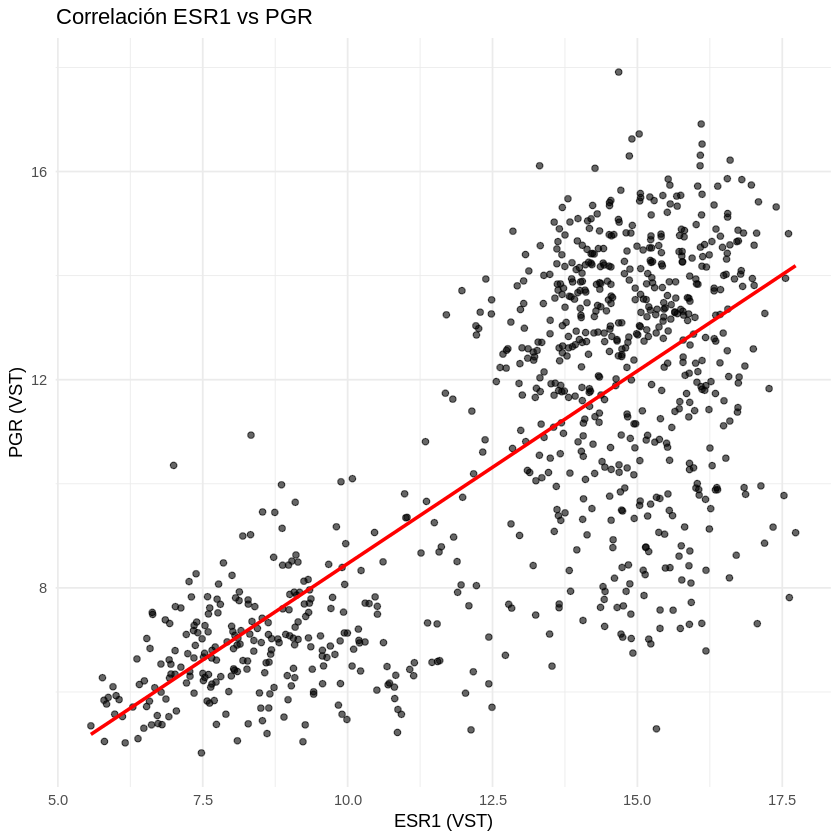

In [32]:
# ===================================================================
# ANÁLISIS DE CORRELACIÓN Y GENERACIÓN DE MAPAS DE CALOR (HEATMAPS)
# ===================================================================

# Definición de genes de interés para el análisis
# Estos genes son marcadores importantes en cáncer de mama y proliferación celular:
# - ESR1: Receptor de estrógeno alfa (hormonal)
# - PGR: Receptor de progesterona (hormonal)
# - GATA3: Factor de transcripción asociado con diferenciación luminal
# - ERBB2: Receptor del factor de crecimiento epidérmico humano 2 (HER2)
# - GRB7: Proteína adaptadora asociada con señalización de crecimiento
# - MKI67: Marcador de proliferación celular (Ki-67)
# - PCNA: Antígeno nuclear de células en proliferación
# - TP53: Gen supresor de tumores p53
# - MDM2: Regulador negativo de p53
# - KRT5, KRT17: Citoqueratinas asociadas con células basales/mioepiteliales
genes_interest <- c("ESR1","PGR","GATA3","ERBB2","GRB7",
                    "MKI67","PCNA","TP53","MDM2","KRT5","KRT17")

# ===================================================================
# PREPARACIÓN DE DATOS PARA ANÁLISIS DE CORRELACIÓN
# ===================================================================

# Extracción del subconjunto de datos y transposición de la matriz
# - mat_vst: matriz de expresión génica normalizada con transformación VST
# - Se extraen solo los genes de interés especificados anteriormente
# - drop = FALSE: mantiene la estructura de matriz aunque sea una sola fila/columna
# - t(): transpone la matriz para que las filas sean muestras y columnas sean genes
#   (formato necesario para calcular correlaciones entre genes)
expr_sub <- t(mat_vst[genes_interest, , drop = FALSE])

# ===================================================================
# CÁLCULO DE MATRIZ DE CORRELACIÓN
# ===================================================================

# Cálculo de la matriz de correlación de Pearson entre genes
# Parámetros:
# - use = "pairwise.complete.obs": utiliza solo observaciones completas para cada par
#   (maneja valores faltantes eliminándolos por pares)
# - method = "pearson": coeficiente de correlación de Pearson (lineal)
cor_mat <- cor(expr_sub, use = "pairwise.complete.obs", method = "pearson")

# ===================================================================
# VISUALIZACIÓN: MAPA DE CALOR DE CORRELACIONES
# ===================================================================

# Generación del mapa de calor de correlaciones
# Parámetros de pheatmap():
# - clustering_distance_rows/cols = "correlation": usa distancia basada en correlación
#   para agrupar genes similares (1-correlación como medida de distancia)
# - main: título del gráfico
heatmap_correlacion <- pheatmap(cor_mat,
         clustering_distance_rows = "correlation",
         clustering_distance_cols = "correlation",
         main = "Correlación entre genes seleccionados (VST)")

# Mostrar el mapa de calor en pantalla
heatmap_correlacion

# Guardar el mapa de calor como archivo PNG de alta resolución
ggsave(
  filename = "plots/11-heatmap_correlacion.png",  # Ruta y nombre del archivo de salida
  plot = heatmap_correlacion,                     # Objeto del gráfico a guardar
  dpi = 300,                                      # Resolución: 300 DPI (calidad publicación)
  width = 6,                                      # Ancho: 6 pulgadas
  height = 6                                      # Alto: 6 pulgadas
)

# ===================================================================
# ANÁLISIS DETALLADO: GRÁFICO DE DISPERSIÓN (SCATTER PLOT)
# ===================================================================

# Creación de data frame con los valores de expresión de ESR1 y PGR
# Estos dos genes son receptores hormonales importantes en cáncer de mama
# y suelen estar correlacionados en tumores luminales
df_scatter <- data.frame(ESR1 = expr_sub[,"ESR1"],
                         PGR  = expr_sub[,"PGR"])

# Generación del gráfico de dispersión
# Componentes del gráfico:
# - geom_point(): puntos de dispersión con transparencia (alpha = 0.6)
# - geom_smooth(): línea de tendencia lineal sin intervalo de confianza
# - method = "lm": ajuste lineal (modelo lineal)
# - se = FALSE: no mostrar error estándar/intervalo de confianza
# - colour = "red": línea de tendencia en color rojo
scatter_plot <- ggplot(df_scatter, aes(x = ESR1, y = PGR)) +
  geom_point(alpha = .6) +                                    # Puntos semitransparentes
  geom_smooth(method = "lm", se = FALSE, colour = "red") +    # Línea de regresión lineal
  labs(title = "Correlación ESR1 vs PGR",                     # Título del gráfico
       x = "ESR1 (VST)", y = "PGR (VST)") +                  # Etiquetas de ejes
  theme_minimal()                                             # Tema minimalista

# Mostrar el gráfico de dispersión
scatter_plot

# Guardar el gráfico de dispersión como archivo PNG
ggsave(
  filename = "plots/12-scatter_plot.png",      # Ruta y nombre del archivo
  plot = scatter_plot,                         # Objeto del gráfico a guardar
  dpi = 300,                                   # Resolución alta (300 DPI)
  width = 6,                                   # Ancho en pulgadas
  height = 6                                   # Alto en pulgadas
)

### Análisis de sobrevida

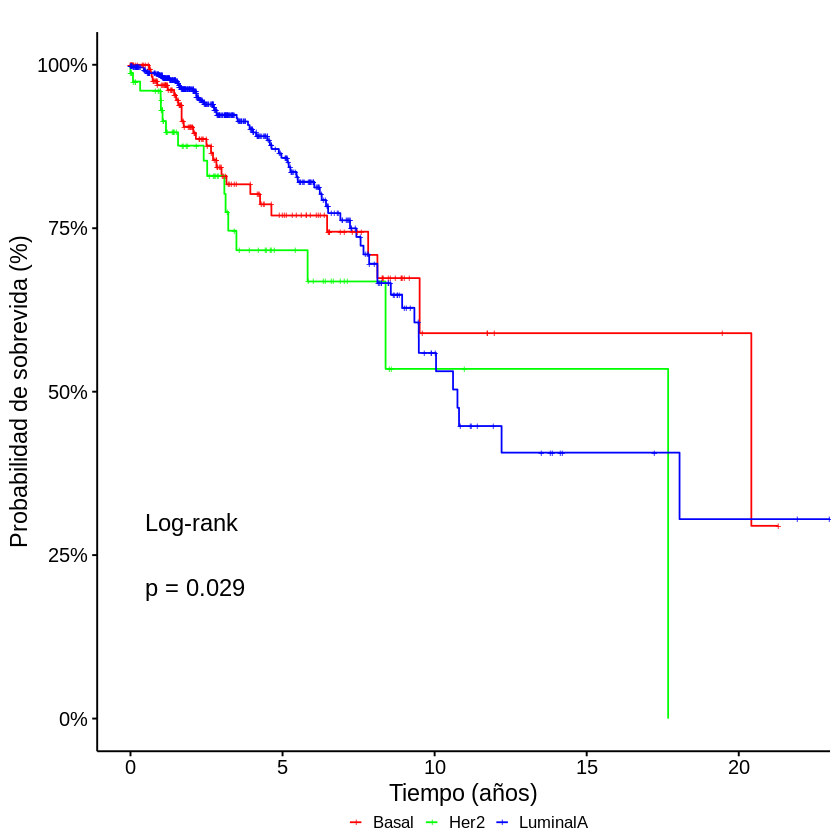

In [33]:
# ===================================================================
# ANÁLISIS DE SUPERVIVENCIA (SURVIVAL ANALYSIS)
# ===================================================================
# Este análisis evalúa la supervivencia de pacientes con cáncer de mama
# utilizando curvas de Kaplan-Meier y comparaciones entre subgrupos

# ===================================================================
# SELECCIÓN Y PREPARACIÓN DE DATOS CLÍNICOS
# ===================================================================

# Definición de las columnas de interés para el análisis de supervivencia
# - patient: identificador único del paciente
# - vital_status: estado vital (vivo/muerto) al final del seguimiento
# - days_to_death: días transcurridos desde el diagnóstico hasta la muerte
# - ajcc_pathologic_stage: estadio patológico según AJCC (American Joint Committee on Cancer)
# - days_to_last_follow_up: días hasta el último seguimiento (para pacientes vivos)
# - paper_BRCA_Subtype_PAM50: subtipo molecular de cáncer de mama según clasificación PAM50
survival_cols <- c("patient", "vital_status", "days_to_death", "ajcc_pathologic_stage", "days_to_last_follow_up",
                   "paper_BRCA_Subtype_PAM50")

# Extracción del subconjunto de datos clínicos con las columnas de interés
clinical_data <- metadatos[, survival_cols]

# ===================================================================
# TRANSFORMACIÓN DE VARIABLES PARA ANÁLISIS DE SUPERVIVENCIA
# ===================================================================

# Creación de variable binaria de estado (event indicator)
# 1 = evento ocurrido (muerte), 0 = censurado (vivo al final del seguimiento)
clinical_data$status <- ifelse(clinical_data$vital_status == "Dead", 1, 0)

# Creación de variable de tiempo hasta el evento
# Si el paciente murió: usar days_to_death
# Si el paciente está vivo: usar days_to_last_follow_up (datos censurados)
clinical_data$time <- ifelse(!is.na(clinical_data$days_to_death),
                             clinical_data$days_to_death,
                             clinical_data$days_to_last_follow_up)

# ===================================================================
# AGRUPACIÓN DE ESTADIOS PATOLÓGICOS
# ===================================================================
# Los estadios se agrupan para simplificar el análisis y aumentar
# el tamaño de muestra en cada grupo

clinical_data <- clinical_data %>%
  mutate(stage_group = case_when(
    # Estadio 0: Carcinoma in situ (no invasivo)
    ajcc_pathologic_stage == "Stage 0"                                               ~ "Stage 0",

    # Estadios tempranos (I-II): tumores localizados con invasión limitada
    ajcc_pathologic_stage %in% c("Stage I","Stage IA","Stage IB",
                                 "Stage II","Stage IIA","Stage IIB")                ~ "Stage I–II",

    # Estadios avanzados (III-IV): invasión local extensa o metástasis
    ajcc_pathologic_stage %in% c("Stage IIIA","Stage IIIB","Stage IIIC",
                                 "Stage IV")                                         ~ "Stage III–IV",

    # Estadio X: estadio no determinable
    ajcc_pathologic_stage == "Stage X"                                               ~ "Stage X",

    # Casos con información faltante
    TRUE                                                                             ~ NA_character_
  )) %>%
  # Conversión de valores NA a "NA" explícito y creación de factor ordenado
  mutate(stage_group = ifelse(is.na(stage_group), "NA", stage_group),
         stage_group = factor(stage_group,
                              levels = c("Stage 0","Stage I–II","Stage III–IV","Stage X","NA"))
  )

# ===================================================================
# FILTRADO DE DATOS PARA ANÁLISIS PRINCIPAL
# ===================================================================

# Selección de pacientes con estadios I-IV (excluyendo Stage 0, X y NA)
# Estos representan los casos de cáncer invasivo con estadificación clara
clin_sub <- clinical_data %>%
  filter(stage_group %in% c("Stage I–II","Stage III–IV")) %>%
  # droplevels(): elimina niveles no utilizados del factor
  mutate(stage_group = droplevels(stage_group))

# ===================================================================
# CONFIGURACIÓN DE TEMA PERSONALIZADO PARA GRÁFICOS
# ===================================================================

# Función para crear un tema personalizado basado en theme_survminer
# %+replace%: reemplaza elementos específicos del tema base
theme_survminer_cent <- function() {
  theme_survminer() %+replace%
    theme(
      plot.title = element_text(size=14, hjust = 0.5),      # Título centrado, tamaño 14
      plot.subtitle = element_text(size=13, hjust = 0.5),   # Subtítulo centrado, tamaño 13
      legend.key.size = unit(0.6, "lines"),                # Tamaño reducido de claves de leyenda
      legend.margin = margin(t=-7, unit="points")           # Margen superior de leyenda ajustado
    )
}

# ===================================================================
# ANÁLISIS DE KAPLAN-MEIER POR SUBTIPO MOLECULAR PAM50
# ===================================================================

# Generación de curvas de supervivencia de Kaplan-Meier
# Comparación entre subtipos moleculares de cáncer de mama (PAM50)
kmPlot_pam50 <- ggsurvplot(
  # Ajuste del modelo de supervivencia usando la fórmula de Surv()
  # Surv(time, status): objeto de supervivencia con tiempo hasta evento y estado
  surv_fit(Surv(time, status) ~ paper_BRCA_Subtype_PAM50, data = clinical_data),

  data = clinical_data,                    # Datos a utilizar
  risk.table = F,                          # No mostrar tabla de riesgo
  conf.int = F,                            # No mostrar intervalos de confianza
  pval = TRUE,                             # Mostrar p-valor del test log-rank
  pval.method = TRUE,                      # Mostrar método estadístico utilizado
  xscale = "d_y",                          # Escala temporal en días convertidos a años
  surv.scale = "percent",                  # Escala de supervivencia en porcentaje
  xlab = "Tiempo (años)",                  # Etiqueta del eje X
  ylab = "Probabilidad de sobrevida (%)",  # Etiqueta del eje Y
  break.time.by = 1826,                    # Marcas en el eje X cada 5 años (1826 días ≈ 5 años)
  legend = "bottom",                       # Posición de la leyenda
  legend.title = "",                       # Sin título en la leyenda
  legend.labs = c("Basal","Her2","LuminalA"), # Etiquetas personalizadas para la leyenda
  title = "",                              # Sin título principal
  censor.size = 2,                         # Tamaño de las marcas de censura
  size = 0.5,                              # Grosor de las líneas de supervivencia
  palette = c("red", "green", "blue"),     # Colores para cada subtipo (Basal=rojo, Her2=verde, LuminalA=azul)
  ggtheme = theme_survminer_cent()         # Aplicación del tema personalizado
)

# Mostrar el gráfico de supervivencia
kmPlot_pam50

# ===================================================================
# EXPORTACIÓN DEL GRÁFICO
# ===================================================================

# Extracción del objeto ggplot del resultado de ggsurvplot
# ggsurvplot devuelve una lista; el gráfico principal está en $plot
kmPlot_pam50 <- kmPlot_pam50$plot

# Guardado del gráfico como archivo PNG de alta resolución
ggsave(
  filename = "plots/13-kmPlot_pam50.png",  # Ruta y nombre del archivo de salida
  plot = kmPlot_pam50,                     # Objeto del gráfico a guardar
  dpi = 300,                               # Resolución: 300 DPI (calidad para publicación)
  width = 6,                               # Ancho: 6 pulgadas
  height = 6                               # Alto: 6 pulgadas
)

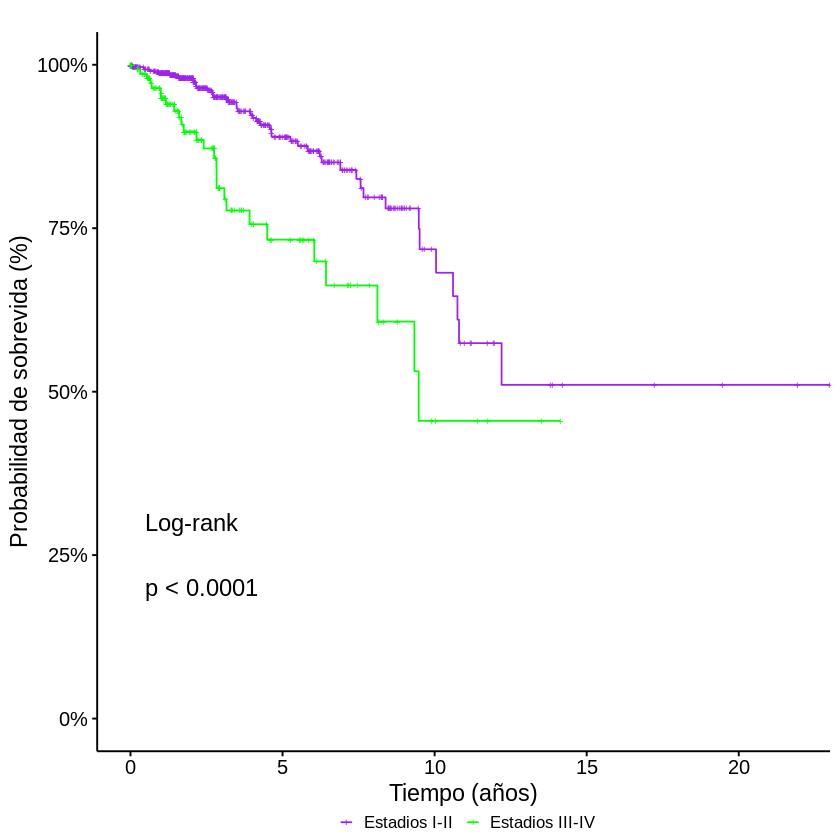

In [34]:
# ===================================================================
# ANÁLISIS DE SUPERVIVENCIA POR ESTADIO PATOLÓGICO AJCC
# ===================================================================
# Este análisis compara la supervivencia entre estadios tempranos (I-II)
# y avanzados (III-IV)

# ===================================================================
# CURVAS DE KAPLAN-MEIER POR ESTADIO AJCC
# ===================================================================

# Generación de curvas de supervivencia comparando estadios agrupados
kmPlot_ajcc <- ggsurvplot(
  # Modelo de supervivencia estratificado por grupos de estadio
  # Se utiliza 'clin_sub' que contiene solo pacientes con estadios I-IV
  # (excluyendo Stage 0, X y casos con información faltante)
  surv_fit(Surv(time, status) ~ stage_group, data = clin_sub),

  data = clin_sub,                         # Dataset filtrado con estadios I-IV únicamente
  risk.table = F,                          # No mostrar tabla de pacientes en riesgo
  conf.int = F,                            # No mostrar bandas de confianza (simplicidad visual)
  pval = TRUE,                             # Mostrar p-valor del test log-rank
  pval.method = TRUE,                      # Indicar el método estadístico utilizado

  # ===================================================================
  # CONFIGURACIÓN DE ESCALAS Y ETIQUETAS
  # ===================================================================
  xscale = "d_y",                          # Convertir días a años para mejor interpretación
  surv.scale = "percent",                  # Mostrar probabilidad como porcentaje (0-100%)
  xlab = "Tiempo (años)",                  # Etiqueta del eje temporal
  ylab = "Probabilidad de sobrevida (%)",  # Etiqueta del eje de supervivencia
  break.time.by = 1826,                    # Marcas cada ~5 años (1826 días = 5 años)

  # ===================================================================
  # CONFIGURACIÓN VISUAL Y LEYENDA
  # ===================================================================
  legend = "bottom",                       # Leyenda en la parte inferior
  legend.title = "",                       # Sin título en la leyenda (más limpio)
  legend.labs = c("Estadios I-II", "Estadios III-IV"), # Etiquetas descriptivas
  title = "",                              # Sin título principal (se puede añadir externamente)

  # ===================================================================
  # PARÁMETROS GRÁFICOS
  # ===================================================================
  censor.size = 2,                         # Tamaño de las marcas de censura (datos truncados)
  size = 0.5,                              # Grosor de las líneas de supervivencia

  # Esquema de colores intuitivo:
  # - Púrpura para estadios tempranos (I-II): mejor pronóstico
  # - Verde para estadios avanzados (III-IV): peor pronóstico
  palette = c("purple", "green"),

  ggtheme = theme_survminer_cent()         # Tema personalizado definido anteriormente
)

# Mostrar el gráfico de supervivencia por estadio AJCC
kmPlot_ajcc

# ===================================================================
# EXTRACCIÓN Y GUARDADO DEL GRÁFICO
# ===================================================================

# Extracción del objeto ggplot desde el resultado de ggsurvplot
# Necesario porque ggsurvplot devuelve una lista con múltiples componentes
kmPlot_ajcc <- kmPlot_ajcc$plot

# Exportación como archivo PNG de alta calidad
ggsave(
  filename = "plots/14-kmPlot_ajcc.png",   # Nombre descriptivo del archivo
  plot = kmPlot_ajcc,                      # Objeto gráfico a guardar
  dpi = 300,                               # Resolución de 300 DPI (estándar para publicación)
  width = 6,                               # Ancho de 6 pulgadas
  height = 6                               # Alto de 6 pulgadas (formato cuadrado)
)

# ===================================================================
# INTERPRETACIÓN CLÍNICA ESPERADA
# ===================================================================
# Este análisis debería mostrar:
# 1. Mayor supervivencia en estadios I-II vs. III-IV
# 2. Separación clara de las curvas (efecto estadio)
# 3. P-valor significativo (< 0.05) confirmando diferencias
# 4. Utilidad para estratificación pronóstica y decisiones terapéuticas

# La diferencia en supervivencia entre estadios es uno de los hallazgos
# más consistentes en oncología y valida la importancia del diagnóstico
# temprano y la estadificación adecuada del cáncer

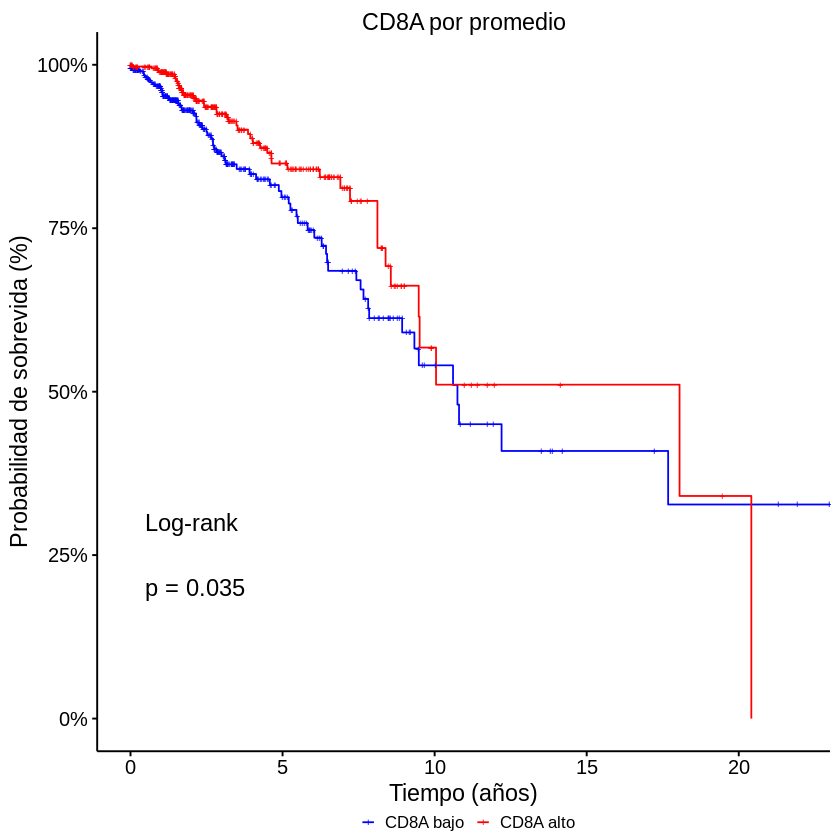

In [35]:
# ===================================================================
# ANÁLISIS DE SUPERVIVENCIA POR EXPRESIÓN DEL GEN CD8A
# ===================================================================
# CD8A codifica para la cadena alfa del receptor CD8, expresado en linfocitos T
# citotóxicos. Su expresión se considera un marcador de infiltración de células T
# CD8+ en el microambiente tumoral, lo cual está asociado con mejor respuesta
# inmunitaria antitumoral y pronóstico favorable en varios tipos de cáncer

# ===================================================================
# EXTRACCIÓN Y PREPARACIÓN DE DATOS DE EXPRESIÓN DE CD8A
# ===================================================================

# Extracción de los valores de expresión del gen CD8A desde la matriz VST
# Se extrae la fila correspondiente a CD8A y se transpone para obtener
# un vector con los valores de expresión para cada muestra
expr_CD8A <- as.data.frame(mat_vst["CD8A", ])
colnames(expr_CD8A) = "CD8A"  # Asignación de nombre descriptivo a la columna

# Integración de los datos de expresión de CD8A con los datos clínicos
# Esto permite correlacionar la expresión génica con los outcomes clínicos
clinical_data$CD8A <- expr_CD8A$CD8A

# ===================================================================
# CÁLCULO DEL PUNTO DE CORTE BASADO EN LA MEDIA
# ===================================================================

# Cálculo del promedio de expresión de CD8A en toda la cohorte
# na.rm = TRUE: excluye valores faltantes del cálculo
# El promedio como punto de corte es una estrategia común pero simple;
# otras alternativas incluyen mediana, cuartiles, o puntos de corte óptimos
CD8A_mean <- mean(clinical_data$CD8A, na.rm = TRUE)

# ===================================================================
# DICOTOMIZACIÓN DE LA EXPRESIÓN DE CD8A
# ===================================================================

# Creación de grupos categóricos basados en la expresión de CD8A
# La dicotomización facilita el análisis de supervivencia y la interpretación clínica
clinical_data <- clinical_data %>%
  mutate(
    CD8A_group = case_when(
      CD8A >= CD8A_mean  ~ "High_CD8A",     # Expresión alta: mayor o igual al promedio
      CD8A <  CD8A_mean  ~ "Low_CD8A"       # Expresión baja: menor al promedio
    ),
    # Conversión a factor con niveles ordenados lógicamente
    # Low_CD8A como referencia (nivel base) para comparaciones estadísticas
    CD8A_group = factor(CD8A_group, levels = c("Low_CD8A","High_CD8A"))
  )

# ===================================================================
# ANÁLISIS DE SUPERVIVENCIA DE KAPLAN-MEIER POR EXPRESIÓN DE CD8A
# ===================================================================

# Generación de curvas de supervivencia comparando alta vs. baja expresión de CD8A
# Hipótesis: Mayor expresión de CD8A (mayor infiltración de linfocitos T citotóxicos)
# debería asociarse con mejor supervivencia debido a mayor respuesta inmunitaria
kmPlot_CD8A_promedio <- ggsurvplot(
  # Modelo de supervivencia estratificado por nivel de expresión de CD8A
  surv_fit(Surv(time, status) ~ CD8A_group, data = clinical_data),

  data = clinical_data,                    # Dataset completo con información de CD8A

  # ===================================================================
  # CONFIGURACIÓN DE VISUALIZACIÓN
  # ===================================================================
  risk.table = F,                          # No mostrar tabla de riesgo
  conf.int = F,                            # No mostrar intervalos de confianza
  pval = TRUE,                             # Mostrar p-valor del test log-rank
  pval.method = TRUE,                      # Indicar método estadístico

  # ===================================================================
  # CONFIGURACIÓN DE ESCALAS TEMPORALES
  # ===================================================================
  xscale = "d_y",                          # Escala en años (conversión de días)
  surv.scale = "percent",                  # Probabilidad de supervivencia en porcentaje
  xlab = "Tiempo (años)",                  # Etiqueta del eje temporal
  ylab = "Probabilidad de sobrevida (%)",  # Etiqueta del eje de supervivencia
  break.time.by = 1826,                    # Marcas temporales cada ~5 años

  # ===================================================================
  # CONFIGURACIÓN DE LEYENDA Y TÍTULO
  # ===================================================================
  legend = "bottom",                       # Posición de la leyenda
  legend.title = "",                       # Sin título en la leyenda
  legend.labs = c("CD8A bajo", "CD8A alto"), # Etiquetas descriptivas en español
  title = "CD8A por promedio",             # Título descriptivo del análisis

  # ===================================================================
  # PARÁMETROS GRÁFICOS
  # ===================================================================
  censor.size = 2,                         # Tamaño de marcas de censura
  size = 0.5,                              # Grosor de líneas de supervivencia

  # Esquema de colores intuitivo:
  # - Azul para CD8A bajo (posible peor pronóstico)
  # - Rojo para CD8A alto (posible mejor pronóstico por mayor inmunidad)
  palette = c("blue", "red"),

  ggtheme = theme_survminer_cent()         # Tema personalizado predefinido
)

# Visualización del gráfico de supervivencia
kmPlot_CD8A_promedio

# ===================================================================
# EXTRACCIÓN Y GUARDADO DEL GRÁFICO
# ===================================================================

# Extracción del componente ggplot del objeto ggsurvplot
kmPlot_CD8A_promedio <- kmPlot_CD8A_promedio$plot

# Exportación como archivo PNG de alta resolución
ggsave(
  filename = "plots/15-kmPlot_CD8A_promedio.png", # Nombre descriptivo del archivo
  plot = kmPlot_CD8A_promedio,             # Objeto gráfico a guardar
  dpi = 300,                               # Resolución de 300 DPI (calidad publicación)
  width = 6,                               # Ancho de 6 pulgadas
  height = 6                               # Alto de 6 pulgadas
)

# ===================================================================
# INTERPRETACIÓN BIOLÓGICA Y CLÍNICA ESPERADA
# ===================================================================
# Resultados esperados:
# 1. Pacientes con alta expresión de CD8A deberían mostrar mejor supervivencia
# 2. La diferencia refleja el papel protector de linfocitos T citotóxicos
# 3. Validación del concepto de "tumores inmunológicamente calientes"
# 4. Potencial biomarcador para inmunoterapia y pronóstico

# CD8A como marcador de microambiente inmunitario:
# - Alta expresión: tumor infiltrado por linfocitos T (mejor pronóstico)
# - Baja expresión: tumor "frío" inmunológicamente (peor pronóstico)
# - Relevancia para estrategias de inmunoterapia en cáncer de mama

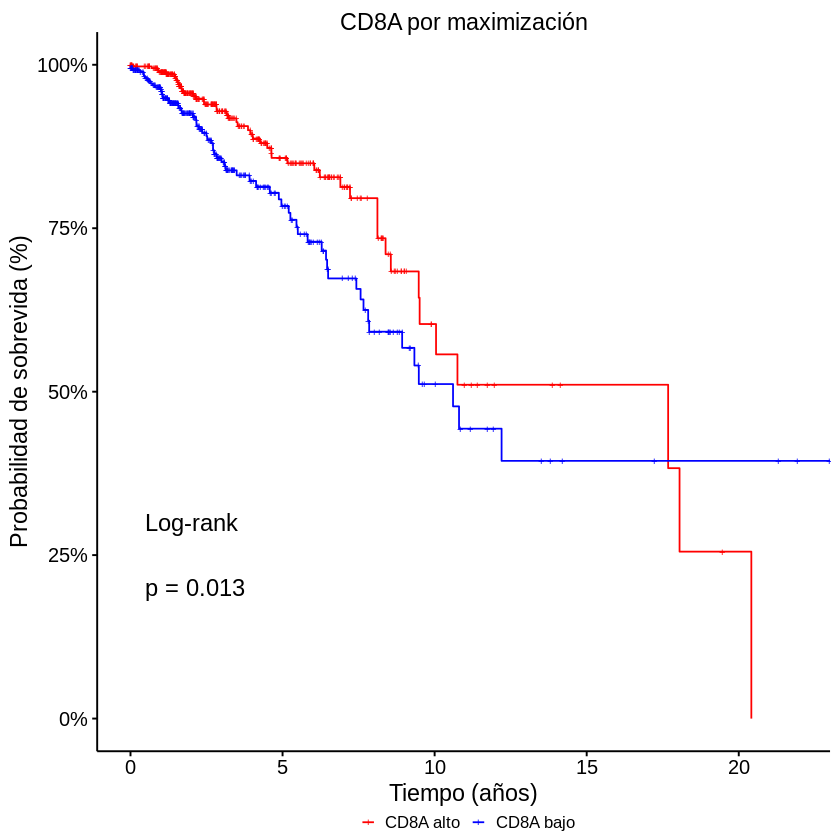

In [36]:
# ===================================================================
# ANÁLISIS DE SUPERVIVENCIA POR EXPRESIÓN DE CD8A - MÉTODO DE MAXIMIZACIÓN
# ===================================================================
# Este análisis utiliza el método de "maxstat" (maximización estadística) para
# determinar el punto de corte óptimo que maximiza la diferencia de supervivencia
# entre grupos, en lugar de usar puntos de corte arbitrarios como la media o mediana

# ===================================================================
# DETERMINACIÓN DEL PUNTO DE CORTE ÓPTIMO
# ===================================================================

# Búsqueda del punto de corte óptimo usando maximización estadística
# Esta técnica evalúa múltiples puntos de corte posibles y selecciona
# aquel que produce la mayor separación estadística entre las curvas de supervivencia
data_cat <- surv_cutpoint(
  clinical_data,                    # Dataset con datos clínicos y de expresión
  time = "time",                    # Variable de tiempo hasta el evento
  event = "status",                 # Variable de estado (0=censurado, 1=evento)
  variables = "CD8A",               # Variable continua a dicotomizar

  # minprop = 0.25: Restricción para evitar grupos muy desbalanceados
  # Asegura que cada grupo tenga al menos 25% de las observaciones
  # Esto previene problemas estadísticos por tamaños de muestra muy pequeños
  minprop = 0.25,

  progressbar = TRUE                # Mostrar barra de progreso durante el cálculo
)

# Aplicación del punto de corte óptimo identificado
# La función surv_categorize aplica el punto de corte determinado anteriormente
# y crea las categorías dicotómicas con etiquetas personalizadas
data_cat <- surv_categorize(data_cat, labels = c("Low","High"))

# ===================================================================
# VENTAJAS DEL MÉTODO DE MAXIMIZACIÓN vs. PUNTOS DE CORTE ARBITRARIOS
# ===================================================================
# Ventajas:
# - Optimización estadística objetiva del punto de corte
# - Maximiza el poder estadístico para detectar diferencias
# - Reduce la arbitrariedad en la dicotomización
# - Puede revelar umbrales biológicamente relevantes

# Desventajas y consideraciones:
# - Riesgo de sobreajuste (overfitting) a los datos específicos
# - Puede inflar artificialmente la significancia estadística

# ===================================================================
# ANÁLISIS DE SUPERVIVENCIA DE KAPLAN-MEIER CON PUNTO DE CORTE ÓPTIMO
# ===================================================================

# Generación de curvas de supervivencia usando el punto de corte optimizado
# Se espera mayor separación entre las curvas comparado con métodos arbitrarios
kmPlot_CD8A_max <- ggsurvplot(
  # Modelo de supervivencia con la nueva categorización optimizada
  surv_fit(Surv(time, status) ~ CD8A, data = data_cat),

  data = data_cat,                         # Dataset con categorización optimizada

  # ===================================================================
  # CONFIGURACIÓN DE VISUALIZACIÓN
  # ===================================================================
  risk.table = F,                          # No mostrar tabla de pacientes en riesgo
  conf.int = F,                            # No mostrar intervalos de confianza
  pval = TRUE,                             # Mostrar p-valor del test log-rank
  pval.method = TRUE,                      # Indicar método estadístico utilizado

  # ===================================================================
  # CONFIGURACIÓN DE ESCALAS Y ETIQUETAS
  # ===================================================================
  xscale = "d_y",                          # Conversión de días a años en eje X
  surv.scale = "percent",                  # Probabilidad de supervivencia en porcentaje
  xlab = "Tiempo (años)",                  # Etiqueta del eje temporal
  ylab = "Probabilidad de sobrevida (%)",  # Etiqueta del eje de supervivencia
  break.time.by = 1826,                    # Marcas en eje X cada ~5 años (1826 días)

  # ===================================================================
  # CONFIGURACIÓN DE LEYENDA Y TÍTULO
  # ===================================================================
  legend = "bottom",                       # Posición de la leyenda
  legend.title = "",                       # Sin título en la leyenda
  legend.labs = c("CD8A alto", "CD8A bajo"), # Etiquetas descriptivas
  title = "CD8A por maximización",         # Título indicando el método utilizado

  # ===================================================================
  # PARÁMETROS GRÁFICOS
  # ===================================================================
  censor.size = 2,                         # Tamaño de las marcas de censura
  size = 0.5,                              # Grosor de las líneas de supervivencia

  # Esquema de colores consistente con análisis previo:
  # - Rojo para CD8A alto (expectativa de mejor supervivencia)
  # - Azul para CD8A bajo (expectativa de peor supervivencia)
  # NOTA: El orden puede cambiar según como surv_categorize asigne las etiquetas
  palette = c("red", "blue"),

  ggtheme = theme_survminer_cent()         # Tema personalizado consistente
)

# Visualización del gráfico de supervivencia optimizado
kmPlot_CD8A_max

# ===================================================================
# EXTRACCIÓN Y GUARDADO DEL GRÁFICO
# ===================================================================

# Extracción del componente ggplot del resultado de ggsurvplot
kmPlot_CD8A_max <- kmPlot_CD8A_max$plot

# Exportación como archivo PNG de alta calidad
ggsave(
  filename = "plots/16-kmPlot_CD8A_max.png", # Nombre indicando método de maximización
  plot = kmPlot_CD8A_max,                    # Objeto gráfico a guardar
  dpi = 300,                                 # Resolución de 300 DPI
  width = 6,                                 # Ancho de 6 pulgadas
  height = 6                                 # Alto de 6 pulgadas
)

# ===================================================================
# INTERPRETACIÓN Y COMPARACIÓN CON ANÁLISIS PREVIO
# ===================================================================
# Comparación esperada con el análisis por promedio:
# 1. Mayor separación estadística entre las curvas
# 2. P-valor potencialmente más significativo